In [1]:
# Ocean Heat Budget Analyses in the Antarctica continental shelf (WAOM)

# Fabio B Dias - 28 June 2023
# Description:
#     this script obtain and save the 1500m isobath contour variables, which is used for the 
#     cross-shelf heat transport estimates

# read nc output from WAOM 10km run

import xarray as xr
import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps
import cmocean

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

import gsw

import pyresample

from dask.distributed import Client
import logging
import warnings
warnings.filterwarnings('ignore')


In [2]:
client = Client(n_workers=56,threads_per_worker=1, memory_limit=0, silence_logs=logging.ERROR)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 56
Total threads: 56,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41619,Workers: 56
Dashboard: /proxy/8787/status,Total threads: 56
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:34213,Total threads: 1
Dashboard: /proxy/33421/status,Memory: 0 B
Nanny: tcp://127.0.0.1:37255,


In [9]:
    %%time
    
    # load ice draft to create masks
    # di = xr.open_dataset('/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag_daily/ocean_avg_0001.nc')
    di = xr.open_dataset('/scratch/gi0/fbd581/waom10extend_shflim_S_0.25Q/output_20yr_notides_diag_daily/ocean_avg_0001.nc')
    ice_draft = di.variables["zice"]
    
    mask_zice = ma.masked_where(ice_draft < 0, np.ones(ice_draft.shape))
    mask_outice = ma.masked_where(ice_draft >= 0, np.ones(ice_draft.shape))
    di.close()
    
    dg = xr.open_dataset("/g/data/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_grd.nc")
    
    lat_rho = dg.variables["lat_rho"]
    lon_rho = dg.variables["lon_rho"]
    lat_u = dg.variables["lat_u"]
    lon_u = dg.variables["lon_u"]
    lat_v = dg.variables["lat_v"]
    lon_v = dg.variables["lon_v"]
    pm = dg.pm
    pn = dg.pn
    h = dg.variables["h"]
    
    # ds.coords['lat_rho']=lat_rho.transpose() # put lat_rho into ds dataset
    # ds.coords['lon_rho']=lon_rho.transpose() # put lon_rho into ds dataset
    
    area=np.divide(1,pm*pn)
    
    ## creating the contour, such as a isobath, and extracting the coordinates using matplotlib's Path class
    # based on https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/Cross-contour_transport.ipynb
    
    h = dg.h.load()
    
    h = h*mask_zice
    
    # Fill in land with zeros:
    h = h.fillna(0)
    
    contour_depth = 1500.
    
    ## Choose whether you want your contour on the u or t grid.
    grid_sel = 't'
    if grid_sel == 'u':
        x_var = lon_u
        y_var = lat_u
    elif grid_sel == 't':
        x_var = lon_rho
        y_var = lat_rho
     
    dg.close()


CPU times: user 61.8 ms, sys: 68.6 ms, total: 130 ms
Wall time: 254 ms


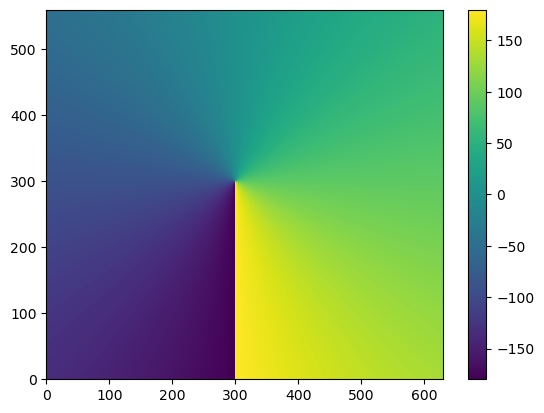

In [10]:
plt.pcolormesh(lon_rho)
plt.colorbar()

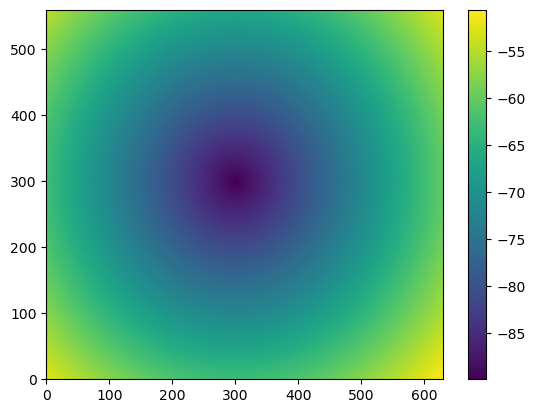

In [11]:
plt.pcolormesh(lat_rho)
plt.colorbar()

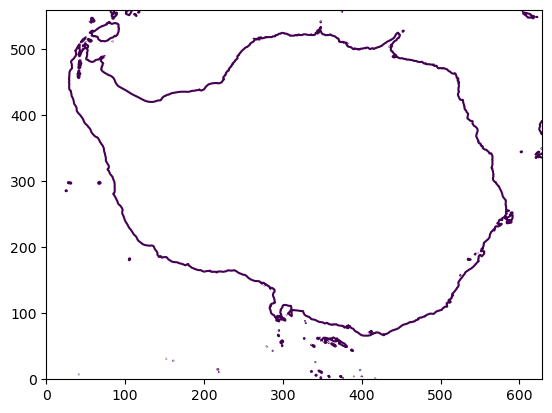

In [12]:
sc = plt.contour(h, levels=[1500])
# plt.xlim(360,410)
# plt.ylim(65,85)

In [13]:
# # first save all contours in individual plot to scam for the number of the desired contour:

# for cc in np.arange(0,213):
#     fig = plt.figure(figsize = (8, 6))
#     count = cc
#     x_contour = []
#     y_contour = []

#     # Create the contour:
#     sc = plt.contour(h, levels=[contour_depth])
#     for collection in sc.collections:
#         for path in collection.get_paths():
#             # print(collection.get_paths())
        
#             count += 1
#             if count ==  212:
#                 # Write down the lat/lon indices
#                 for ii in range(np.size(path.vertices[:,0])):
#                     x_contour.append(int(np.round(path.vertices[ii][0])))
#                     y_contour.append(int(np.round(path.vertices[ii][1])))

#     plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato');

#     name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/waom10extend_1500m_contour_cc=" + str(cc) + ".png"
#     plt.savefig(name_fig, dpi=300)
#     plt.close()

# THIS DOESN'T WORK ANYMORE (FEB24); IT KEEP GATHERING ALL CONTOURS. HAD TO SEPARATE IT MANUALLY (SEE BELOW).

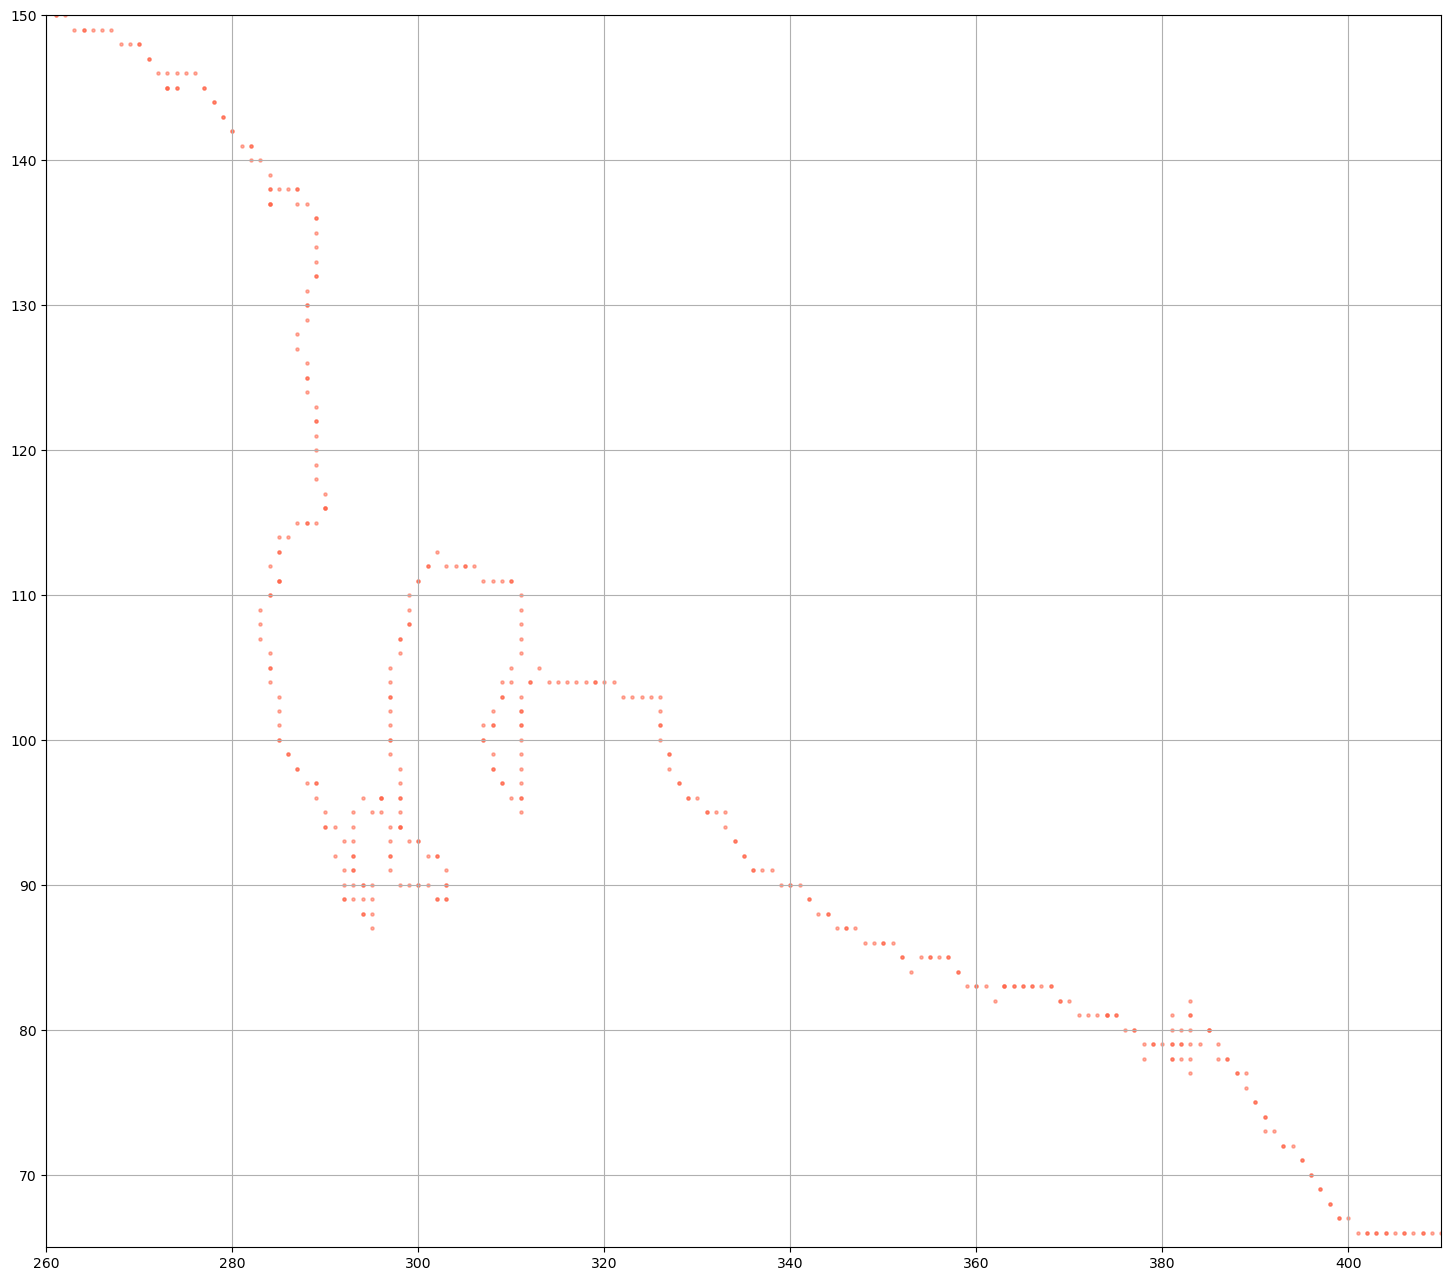

In [14]:
fig = plt.figure(figsize = (18, 16))
count = 0
x_contour = []
y_contour = []

# Create the contour:
# sc = plt.contour(h, levels=[contour_depth])
for collection in sc.collections:
    for path in collection.get_paths():
        
        count += 1
        
        if count == 1:
            # Write down the lat/lon indices
            for ii in range(np.size(path.vertices[:,0])):
                x_contour.append(int(np.round(path.vertices[ii][0])))
                y_contour.append(int(np.round(path.vertices[ii][1])))

xi=494
xf=3279
plt.scatter(x_contour[xi:xf], y_contour[xi:xf], s=5, alpha=0.5, color='tomato');
# plt.xlim(300,450)
# plt.ylim(50,100)
plt.xlim(260,410)
plt.ylim(65,150)
plt.grid('on')

In [15]:
xf-xi
# cut only circum-antarctic contour:
x_contour = x_contour[xi:xf]
y_contour = y_contour[xi:xf]


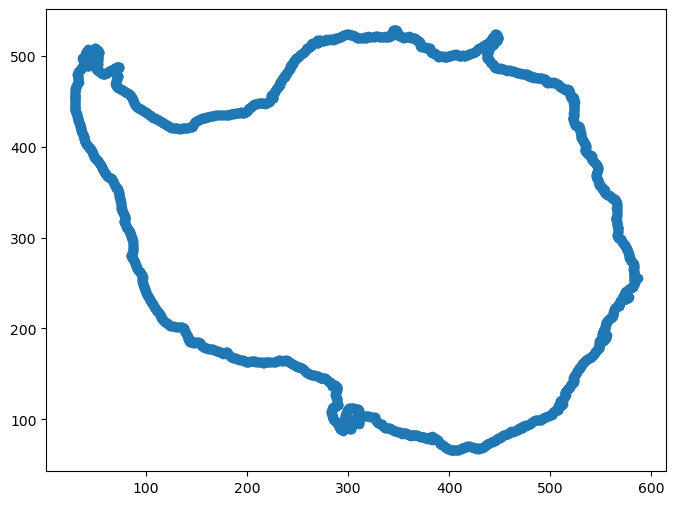

In [16]:

fig = plt.figure(figsize = (8, 6))

# plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='k');#tomato');
plt.plot(x_contour, y_contour,'o')
# plt.ylim(350,520)
# plt.xlim(0,100)
# plt.xlim(300,450)
# plt.ylim(50,100)
# plt.xlim(260,410)
# plt.ylim(65,150)

In [17]:
len(x_contour)

2785

In [18]:
# # save x_contour, y_contour

# xcon_np = np.asarray(x_contour)
# np.savetxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM10_1500m_x_contour.csv", xcon_np, delimiter=",")

# ycon_np = np.asarray(y_contour)
# np.savetxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM10_1500m_y_contour.csv", ycon_np, delimiter=",")


In [19]:
# to re-load
xcon_np=np.loadtxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM10_1500m_x_contour.csv")
x_contour = xcon_np.tolist()
ycon_np=np.loadtxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM10_1500m_y_contour.csv")
y_contour = ycon_np.tolist()

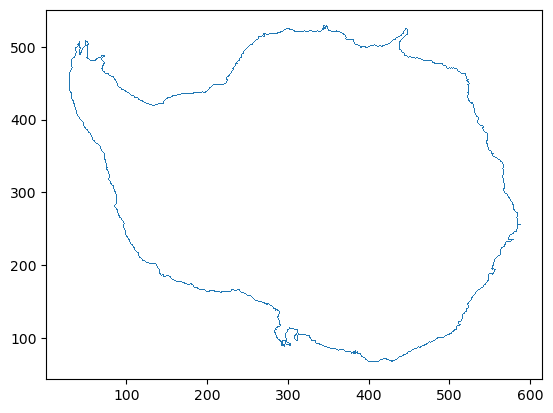

In [20]:
plt.plot(x_contour, y_contour,',')

In [21]:
# for ii in range(0,len(x_contour)):
#         # ?contour_mask[y_contour[ii], x_contour[ii]] = contour_mask_numbered[ii]+1
#         print(int(y_contour[ii]), int(x_contour[ii]))

#### calculate vol_transp here for testing - are the cross-contour transports correct?


In [22]:
# Difference between two neighbouring indices
diff_x_contour = np.diff(x_contour)
diff_y_contour = np.diff(y_contour)

# Get a list with the indices of duplicates
diff_ind = []
for ii in range(len(diff_x_contour)):
    if (diff_x_contour[ii]==0) and (diff_y_contour[ii]==0):
        diff_ind.append(ii)
# print(diff_ind)
# Now remove the indices (start from the end so the indices don't shift)
for ii in range(len(diff_ind)):
    index = diff_ind[::-1][ii]
    del x_contour[index]
    del y_contour[index]

h_contour = np.zeros(len(x_contour))

for ii in range(len(h_contour)):
    h_contour[ii] = h[int(y_contour[ii]), int(x_contour[ii])]

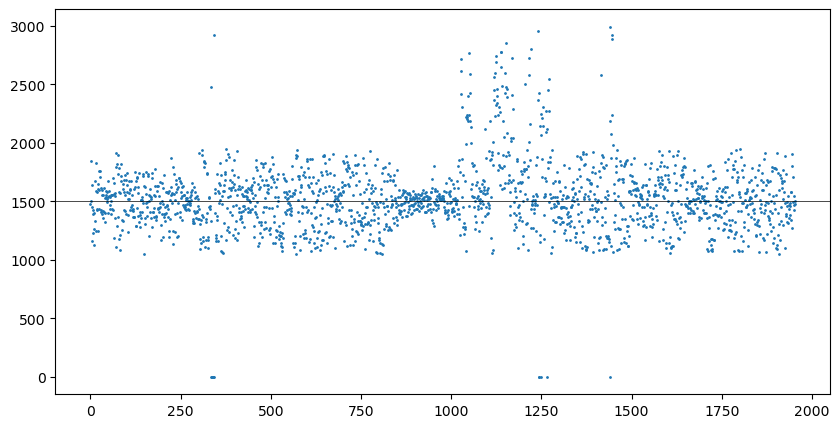

In [23]:
fig = plt.figure(figsize=(10, 5))

plt.plot(h_contour, 'o', markersize=1)
plt.axhline(contour_depth, color='k', linewidth=0.5);

In [24]:
# Get lat/lon along the contour

# Choose whether you want your contour on the u or t grid.
grid_sel = 't'

if grid_sel == 'u':
    x_var = lon_u
    y_var = lat_u
elif grid_sel == 'v':
    x_var = lon_v
    y_var = lat_v
elif grid_sel == 't':
    x_var = lon_rho
    y_var = lat_rho

lat_along_contour = np.zeros((len(x_contour)))
lon_along_contour = np.zeros((len(x_contour)))

for ii in range(len(h_contour)):
    lon_along_contour[ii] = x_var[int(y_contour[ii-1]),int(x_contour[ii-1])]
    lat_along_contour[ii] = y_var[int(y_contour[ii-1]),int(x_contour[ii-1])]

# Repeat the leftmost point at the end of the array.
# (Required for masking contour above and below)

lat_along_contour = np.append(lat_along_contour, lat_along_contour[0])
lon_along_contour = np.append(lon_along_contour, lon_along_contour[0])

# Number of grid points on the contour
num_points = len(lat_along_contour)

# Now we number the points along the contour
contour_mask_numbered = np.zeros_like(lon_along_contour)

for ii in range(num_points-1):
    # lat1 = lat_along_contour[ii]
    # lat2 = lat_along_contour[ii+1]
    # lon1 = lon_along_contour[ii]
    # lon2 = lon_along_contour[ii+1]
    contour_mask_numbered[ii] = ii

contour_mask = h*0

In [25]:
#Create mask
#Now we create a mask below contour so that the direction of the contour can be determined

#Remark on computational inefficiency:
#Note that creating masks with nested for loops is very inefficient. We should probably use boolean masks (just compare the entire array with mask_value), and DataArray.shift() or DataArray.roll() from each of the directions to generate the masks without using loops.
#See discussion in: https://github.com/COSIMA/cosima-recipes/issues/179

for ii in range(num_points-1):
    contour_mask[int(y_contour[ii]), int(x_contour[ii])] = contour_mask_numbered[ii]+1
mask_value = -1000
contour_mask_numbered = contour_mask

# fill in points to south of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1, 0] = mask_value # this makes pt x=0, y=-1 equal to -1000
# then this will be the first point to enter in the fiirst IF-case in the next cell;


In [26]:
#from top left:
for ii in range(len(contour_mask[0,:])-1): #x: len(x-axis) - 1
    for jj in range(len(contour_mask[:,0]))[::-1][:-1]: #y: len(y-axis)[from end to start, inverse order][from first to (end-1)]
        if contour_masked_above[jj, ii] == mask_value: # if north of contour line
            if contour_masked_above[jj-1, ii] == 0: # if previous cell in Y-dir is zero (= south of contour line)
                contour_masked_above[jj-1, ii] = mask_value # make it -1000
            if contour_masked_above[jj, ii+1] == 0: # if next cell in X-dir is zero
                contour_masked_above[jj, ii+1] = mask_value # make it -1000

#from top right:
for ii in range(len(contour_mask[0,:]))[::-1][:-1]:
    for jj in range(len(contour_mask[:,0]))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0: # if previous cell in Y-dir is zero
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0: # if previous cell in X-dir is zero
                contour_masked_above[jj, ii-1] = mask_value

# from bottom right:
for ii in range(len(contour_mask[0,:]))[::-1][:-1]:
    for jj in range(len(contour_mask[:,0])-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0: # if next cell in Y-dir is zero
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0: # if previous cell in X-dir is zero
                contour_masked_above[jj, ii-1] = mask_value

#from bottom left:
for ii in range(len(contour_mask[0,:])-1):
    for jj in range(len(contour_mask[:,0])-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0: # if next cell in Y-dir is zero
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0: # if next cell in X-dir is zero
                contour_masked_above[jj, ii+1] = mask_value

In [27]:
# save contour_masked_above
files_path = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
# contour_masked_above.dump(files_path + 'WAOM10_contour_masked_above_1500m_v3')

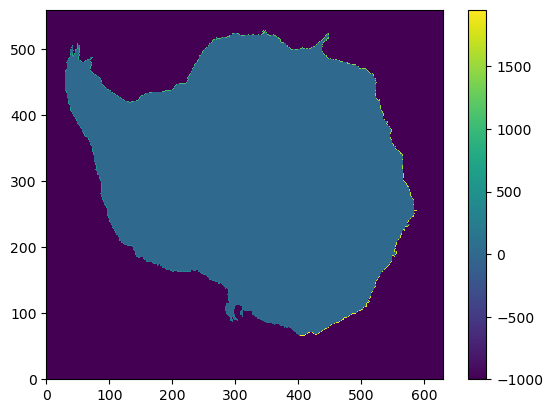

In [28]:
plt.pcolormesh(contour_masked_above)#, vmin=650, vmax=850)
plt.colorbar()
# plt.xlim(300,600)
# plt.ylim(0,300)

In [29]:
# Direction of cross-contour transport

mask_x_transport = np.zeros_like(lon_u)
mask_y_transport = np.zeros_like(lon_v)

mask_x_transport_numbered = np.zeros_like(lon_u)
mask_y_transport_numbered = np.zeros_like(lon_v)

shape = contour_masked_above.shape


In [30]:
int(np.max(contour_mask_numbered))+1

1955

Session below is essential to get the correct transports.

- I need to carefully consider the u/v grid in C-Grid for ROMS; logic below is thought for MOM5 B-Grid (which is quite different).

- update: (notes on my ipad - 14/6/24) It seems that the indexing remains the same with the logic below. It is also needed to add the loop/embayment part.

- Christina comment: the counter along contour isn't monotonic anymore with the embayment part, but it's not overly a concern (only messing up a few points in longitude).

In [31]:
new_number_count = 1
for mask_loc in range(1, int(np.max(contour_mask_numbered))+1):
    #if mask_loc%100 == 0:
    #    print('mask for x/y transport at point '+str(mask_loc))
    index_i = np.where(contour_mask_numbered==mask_loc)[1]
    index_j = np.where(contour_mask_numbered==mask_loc)[0]
    
    # 1A) if point above is towards Antarctica and point below is away from Antarctica:
    # take transport grid point to north of t grid: (same as t-grid index)
    if (contour_masked_above[index_j+1, index_i]==0) and (contour_masked_above[index_j-1, index_i]!=0):
        mask_y_transport[index_j, index_i] = -1
        # important to do
        mask_y_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
        
    # 1B) if point below is towards Antarctica and point above is away from Antarctica:
    # take transport grid point to south of t grid: (j=-1 from t-grid index)
    elif (contour_masked_above[index_j-1, index_i]==0) and (contour_masked_above[index_j+1, index_i]!=0):
        mask_y_transport[index_j-1, index_i] = 1
        mask_y_transport_numbered[index_j-1, index_i] = new_number_count
        new_number_count += 1
        
    # 1C) if point below and point above are BOTH towards Antarctica:
    # take transport grid point to south of t grid: (Embayment case; where t-grid is surronded by both points towards Antarctica)
    elif (contour_masked_above[index_j-1, index_i]==0) and (contour_masked_above[index_j+1, index_i]==0):
        mask_y_transport[index_j-1, index_i] = 1
        mask_y_transport[index_j, index_i] = -1
        mask_y_transport_numbered[index_j-1, index_i] = new_number_count
        mask_y_transport_numbered[index_j, index_i] = new_number_count+1
        new_number_count += 2
        
    # 2A) if point to right is towards Antarctica and point to left is away from Antarctica:
    # take transport grid point on right of t grid: (same as t-grid index)
    if (contour_masked_above[index_j, index_i+1]==0) and (contour_masked_above[index_j, index_i-1]!=0):
        mask_x_transport[index_j, index_i] = -1
        mask_x_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
        
    # 2B) if point to left is towards Antarctica and point to right is away from Antarctica:
    # take transport grid point on left of t grid: (i=-1 from t-grid index)
    elif (contour_masked_above[index_j, index_i-1]==0) and (contour_masked_above[index_j, index_i+1]!=0):
        mask_x_transport[index_j, index_i-1] = 1
        mask_x_transport_numbered[index_j, index_i-1] = new_number_count
        new_number_count += 1
        
    # 2C) if point to left and right BOTH toward Antarctica
    elif (contour_masked_above[index_j, index_i-1]==0) and (contour_masked_above[index_j, index_i+1]==0):
        mask_x_transport[index_j, index_i-1] = 1
        mask_x_transport[index_j, index_i] = -1
        mask_x_transport_numbered[index_j, index_i-1] = new_number_count
        mask_x_transport_numbered[index_j, index_i] = new_number_count+1
        new_number_count += 2

In [32]:
np.max(mask_x_transport_numbered)

2682.0

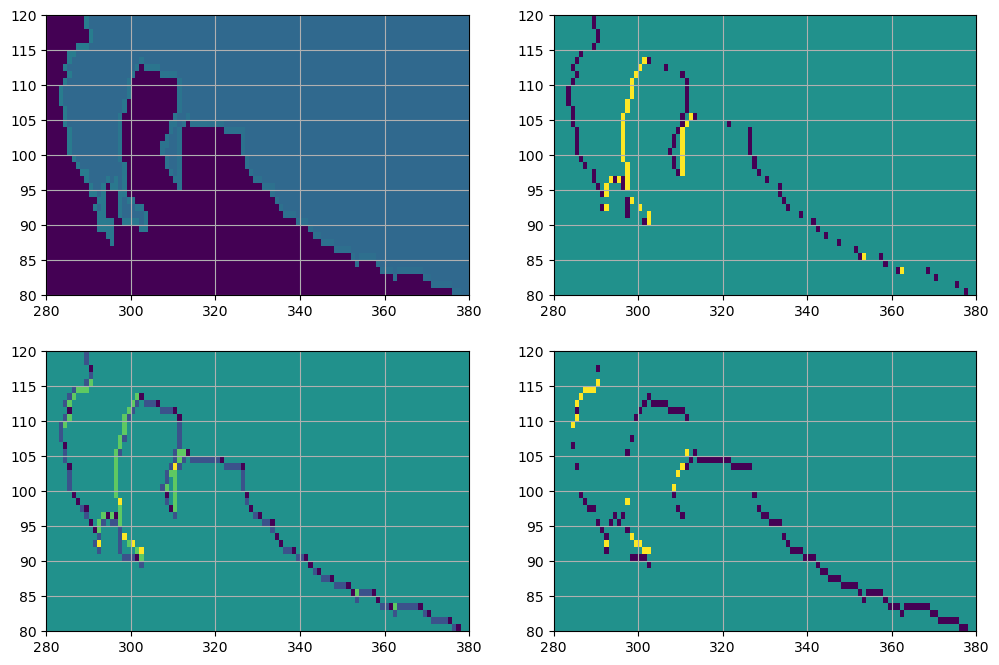

In [33]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize = (12, 8))

aa=ax[0,0].pcolormesh(contour_masked_above)
# plt.colorbar(aa)
ax[0,0].set_xlim(280,380)
ax[0,0].set_ylim(80,120)
ax[0,0].grid('on')

ax[0,1].pcolormesh(mask_x_transport)#[:-1,:]+mask_y_transport[:,:-1])#, vmin=0, vmax=100)
ax[0,1].set_xlim(280,380)
ax[0,1].set_ylim(80,120)
ax[0,1].grid('on')

ax[1,1].pcolormesh(mask_y_transport)#[:-1,:]+mask_y_transport[:,:-1])#, vmin=0, vmax=100)
ax[1,1].set_xlim(280,380)
ax[1,1].set_ylim(80,120)
ax[1,1].grid('on')

ax[1,0].pcolormesh(mask_x_transport[:-1,:]+mask_y_transport[:,:-1])#, vmin=0, vmax=100)
ax[1,0].set_xlim(280,380)
ax[1,0].set_ylim(80,120)
ax[1,0].grid('on')

In [34]:
# plt.pcolormesh(Net_HT.sum('s_rho').mean('ocean_time')*1e-12, cmap='bwr', vmin=-6, vmax=6)
# plt.xlim(260,310)
# plt.ylim(80,120)
# plt.grid('on')
# plt.colorbar()

In [35]:
print(mask_y_transport.shape)
print(lon_rho.shape)
print(lat_rho.shape)

(559, 630)
(560, 630)
(560, 630)


In [36]:
dg = xr.open_dataset("/g/data/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_grd.nc")

# save mask_x/y_transport for inspection;
coordinates=dict(lon=(['lon_rho','lat_rho'],dg.lon_rho.data), lat=(['lon_rho','lat_rho'], dg.lat_rho.data))
coordinatesU=dict(lon=(['lon_u','lat_u'],dg.lon_u.data), lat=(['lon_u','lat_u'], dg.lat_u.data))
coordinatesV=dict(lon=(['lon_v','lat_v'],dg.lon_v.data), lat=(['lon_v','lat_v'], dg.lat_v.data))

mask_x_transport_xr = xr.DataArray(mask_x_transport, coords = coordinatesU, dims = ['lon_u','lat_u'])
mask_y_transport_xr = xr.DataArray(mask_y_transport, coords = coordinatesV, dims = ['lon_v','lat_v'])

# rename vars:
mask_x_transport_xr.name = 'mask_x_transport'
mask_y_transport_xr.name = 'mask_y_transport'

files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross-1500m_transp/'

mask_x_transport_xr.to_netcdf(files_path + 'mask_x_transport.nc', mode='w', format="NETCDF4")
mask_y_transport_xr.to_netcdf(files_path + 'mask_y_transport.nc', mode='w', format="NETCDF4")


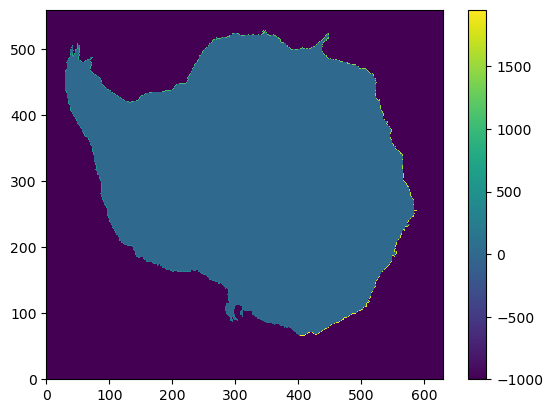

In [37]:
plt.pcolormesh(contour_masked_above)#, vmin=0, vmax=100)
plt.colorbar()
# plt.xlim(260,410)
# plt.ylim(65,150)
# plt.xlim(350,410)
# plt.ylim(60,90)
# plt.xlim(20,40)
# plt.ylim(420,440)

In [38]:
# Convert contour masks to data arrays, so we can multiply them later.
# We need to ensure the lat lon coordinates correspond to the actual data location:
#       The y masks are used for ty_trans, so like vhrho this should have dimensions (yu_ocean, xt_ocean).
#       The x masks are used for tx_trans, so like uhrho this should have dimensions (yt_ocean, xu_ocean).
#       However the actual name will always be simply y_ocean/x_ocean irrespective of the variable
#       to make concatenation of transports in both direction and sorting possible.
coordinates=dict(one=lon_rho, two=lat_rho)
coordinatesU=dict(one=lon_u, two=lat_u)
coordinatesV=dict(one=lon_v, two=lat_v)

mask_x_transport = xr.DataArray(mask_x_transport, coords = coordinatesU, dims = ['eta_u', 'xi_u'])
mask_y_transport = xr.DataArray(mask_y_transport, coords = coordinatesV, dims = ['eta_v', 'xi_v'])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords = coordinatesU, dims = ['eta_u', 'xi_u'])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords = coordinatesV, dims = ['eta_v', 'xi_v'])

# rename dimensions as simply eta/xi
mask_x_transport = mask_x_transport.rename({'eta_u': 'eta','xi_u': 'xi'})
mask_y_transport = mask_y_transport.rename({'eta_v': 'eta','xi_v': 'xi'})
mask_x_transport_numbered = mask_x_transport_numbered.rename({'eta_u': 'eta','xi_u': 'xi'})
mask_y_transport_numbered = mask_y_transport_numbered.rename({'eta_v': 'eta','xi_v': 'xi'})

# Create the contour order data-array. Note that in this procedure the x-grid counts have x-grid
#   dimensions and the y-grid counts have y-grid dimensions, but these are implicit, the dimension
#   *names* are kept general across the counts, the generic y_ocean, x_ocean, so that concatening works
#   but we dont double up with numerous counts for one lat/lon point.

# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['eta', 'xi'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)

mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['eta', 'xi'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)

contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim = 'contour_index', data_vars="all")
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1, len(contour_ordering)+1)

In [39]:
np.max(mask_x_transport_numbered)

<xarray.DataArray ()> Size: 8B
array(2682.)

Question for Claire/Christina: why the count changes after the mask_x/y_transport is created? Are there any duplicates? Each grid along contour should fall in one of the 6 categories, so the counting along contour shouldn't change?

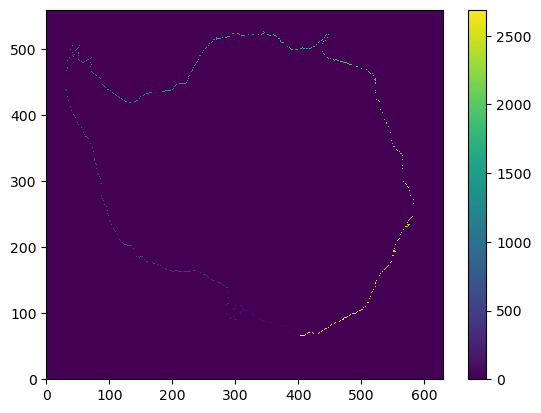

In [40]:
plt.pcolormesh(mask_y_transport_numbered)#[:,:-1]-mask_x_transport_numbered[:-1,:])
plt.colorbar()
# plt.xlim(0,100)
# plt.ylim(400,500)

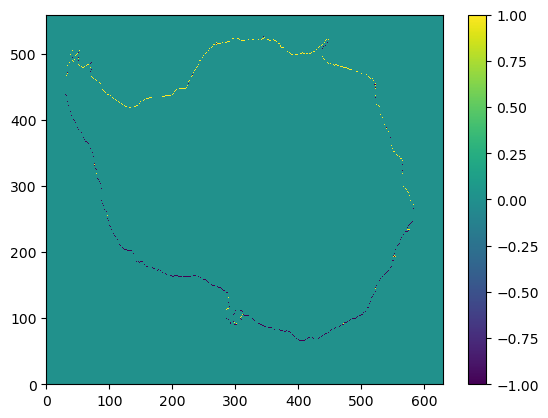

In [41]:
plt.pcolormesh(mask_y_transport)
plt.colorbar()
# plt.xlim(0,100)
# plt.ylim(400,500)

In [42]:
# get lat and lon along contour, useful for plotting later:
lat_along_contour = contour_ordering.two
lon_along_contour = contour_ordering.one

contour_index_array = np.arange(1, len(contour_ordering)+1)

# don't need the multi-index anymore, replace with contour count and save
lat_along_contour.coords['contour_index'] = contour_index_array
lon_along_contour.coords['contour_index'] = contour_index_array

In [37]:
print(pm.shape, pn.shape)

(560, 630) (560, 630)


In [44]:
# using xr.open_mfdataset

vars2drop = ["ubar","vbar","w","Hsbl","Hbbl","swrad"]

ds = xr.open_mfdataset(paths="/scratch/gi0/fbd581/waom10extend_shflim_S_0.25Q/output_20yr_notides_diag_daily/ocean_avg_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=True, drop_variables=vars2drop, decode_times=False)

#- preserving daily avgs
temp = ds.temp
# salt = ds.variables["salt"]
# shflux = ds.variables["shflux"]
# ssflux = ds.variables["ssflux"]
# m = ds.variables["m"]
HvomT = ds.variables["Hvom_temp"]       ## !!! Huon_temp/Hvom_temp were not saved in the original run
HuonT = ds.variables["Huon_temp"]       ## now it's running here: /scratch/gi0/fbd581/waom4extend_shflim_S_0.25Q/output_yr10_diag
Hvom = ds.variables["Hvom"]
Huon = ds.variables["Huon"]
ssh = ds.variables["zeta"]

ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])

print("Vtransform=2")
hwater = ds.h - abs(ds.zice)
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * hwater) / (ds.hc + hwater)
z_rho = ds.zeta + (ds.zeta + hwater) * Zo_rho - abs(ds.zice)
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * hwater) / (ds.hc + hwater)
z_w = ds.zeta + (ds.zeta + hwater) * Zo_w - abs(ds.zice)


ds.close()

Vtransform=2


In [45]:
# compute layer thickness (on rho-grid):
Z_w = z_w.transpose('ocean_time','s_w','eta_rho','xi_rho')

print(Z_w.shape)
Dz = Z_w.diff('s_w') # thickness w/ 31 layers

Dz = Dz.rename({'s_w': 's_rho'})

(365, 32, 560, 630)


In [46]:
ds = xr.open_mfdataset(paths="/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag_daily/ocean_dia_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=True, drop_variables=vars2drop, decode_times=False)

#- preserving daily avgs
temp_hadv = ds.temp_hadv

ds.close()

In [47]:
print(HuonT.shape,HvomT.shape, temp_hadv.shape, Dz.shape)

(365, 31, 560, 629) (365, 31, 559, 630) (365, 31, 560, 630) (365, 31, 560, 630)


In [48]:
heat_hadv = temp_hadv*Dz

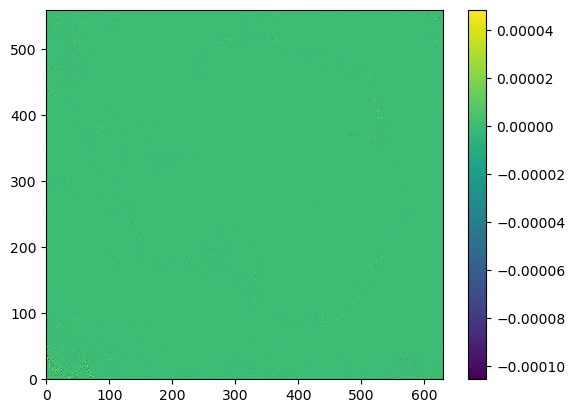

In [49]:
plt.pcolormesh(temp_hadv[0,0,:])
plt.colorbar()

In [50]:
# give i,j index
# I=range(160,165)
# J=range(160,165)
# I_1=range(159,164)
# J_1=range(159,164)

I=100
J=100
I_1=99
J_1=99

In [51]:
tadv = temp_hadv[0,:,J,I].values # degC s-1
t = temp[0,:,J,I].values # degC
dz = Dz[0,:,J,I].values # m
m=1/pm[J,I].values #m
n=1/pn[J,I].values #m

In [52]:
np.sum(dz*tadv)*m*n # m3 degC s-1

3917.9858748808288

In [53]:
print(np.sum(HuonT[0,:,J,I].sum('s_rho').values-
     HuonT[0,:,J,I_1].sum('s_rho').values+
     HvomT[0,:,J,I].sum('s_rho').values-
     HvomT[0,:,J_1,I].sum('s_rho').values))

# sum vert first

-31.375


In [54]:
# this direction: is the right direction J,I (eta,xi)
huonT = HuonT[0,:,J,I].values # m3 degC s-1
huonT_ = HuonT[0,:,J,I_1].values
hvomT = HvomT[0,:,J,I].values
hvomT_ = HvomT[0,:,J_1,I].values

np.sum(hvomT-hvomT_+huonT-huonT_, axis=0)
# sum vert after suming (should be more precise)

-31.525024

In [55]:
print(HuonT.shape, HvomT.shape)

(365, 31, 560, 629) (365, 31, 559, 630)


should test the same with a NOTIDE expt (running daily data 4/6/24):

In [56]:
%%time

xlen=560
ylen=630

HADV=np.empty((ylen,xlen))
HUON_VOM_T=np.empty((ylen,xlen))
# for I in range(xlen-1):
#     for J in range(ylen-1):
for I in range(1,xlen-2):
    for J in range(1,ylen-2):
        
        tadv = temp_hadv[0,:,J,I].values # degC s-1
        t = temp[0,:,J,I].values # degC
        dz = Dz[0,:,J,I].values # m
        m=1/pm[J,I].values #m
        n=1/pn[J,I].values #m
        HADV[J,I] = np.sum(dz*tadv)*m*n # m3 degC s-1

        huonT = HuonT[0,:,J,I].values # m3 degC s-1
        hvomT = HvomT[0,:,J,I].values
        huonT_ = HuonT[0,:,J,I-1].values
        hvomT_ = HvomT[0,:,J-1,I].values
        HUON_VOM_T[J,I] = np.sum((hvomT-hvomT_)+(huonT-huonT_))

        # if I==0:
        #     huonT = HuonT[0,:,J,I].values # m3 degC s-1
        #     hvomT = HvomT[0,:,J,I].values
        #     hvomT_ = HvomT[0,:,J-1,I].values   
        #     HUON_VOM_T[J,I] = np.sum((hvomT-hvomT_)+(huonT))
        # elif J==0:
        #     huonT = HuonT[0,:,J,I].values # m3 degC s-1
        #     hvomT = HvomT[0,:,J,I].values
        #     huonT_ = HuonT[0,:,J,I-1].values
        #     HUON_VOM_T[J,I] = np.sum((hvomT)+(huonT-huonT_))
        # elif I==0 and J==0:
        #     huonT = HuonT[0,:,J,I].values # m3 degC s-1
        #     hvomT = HvomT[0,:,J,I].values
        #     HUON_VOM_T[J,I] = np.sum((hvomT)+(huonT))
        # elif I==(xlen-2):
        #     huonT = HuonT[0,:,J,I].values # m3 degC s-1
        #     huonT_ = HuonT[0,:,J,I-1].values
        #     hvomT_ = HvomT[0,:,J-1,I].values
        #     HUON_VOM_T[J,I] = np.sum((-hvomT_)+(huonT-huonT_))
        # elif J==(ylen-2):
        #     hvomT = HvomT[0,:,J,I].values
        #     huonT_ = HuonT[0,:,J,I-1].values
        #     hvomT_ = HvomT[0,:,J-1,I].values
        #     HUON_VOM_T[J,I] = np.sum((hvomT-hvomT_)+(-huonT_))
        # elif I==(xlen-2) and J==(ylen-2):   
        #     huonT_ = HuonT[0,:,J,I-1].values
        #     hvomT_ = HvomT[0,:,J-1,I].values
        #     HUON_VOM_T[J,I] = np.sum((-hvomT_)+(-huonT_))
        # elif I==0 and J==(ylen-1):   
        #     huonT_ = HuonT[0,:,J,I].values
        #     hvomT = HvomT[0,:,J-1,I].values
        #     HUON_VOM_T[J,I] = np.sum((hvomT)+(huonT))
        # elif J==0 and I==(xlen-1):   
        #     huonT = HuonT[0,:,J,I-1].values
        #     hvomT = HvomT[0,:,J,I].values
        #     HUON_VOM_T[J,I] = np.sum((hvomT)+(huonT))
        # else:
        #     huonT = HuonT[0,:,J,I].values # m3 degC s-1
        #     hvomT = HvomT[0,:,J,I].values
        #     huonT_ = HuonT[0,:,J,I-1].values
        #     hvomT_ = HvomT[0,:,J-1,I].values
        #     HUON_VOM_T[J,I] = np.sum((hvomT-hvomT_)+(huonT-huonT_))
       

IndexError: Index 559 is out of bounds for axis 2 with size 559

In [58]:
J



559

In [64]:
HADV[1:10,0:10]


array([[             nan,  2.24363466e+004,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan],
       [             nan,  2.34352881e+004,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan],
       [             nan,  1.03093487e+004,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan],
       [             nan,  2.54164807e+004,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan],
       [             nan,  3.06456301e+004,              nan,
                     nan,              nan,              nan,
                     nan

In [65]:
HUON_VOM_T[1:10,0:10]


array([[ 2.80000000e+02,  3.41690234e+04,  2.81000000e+02,
         0.00000000e+00,  2.82000000e+02,  0.00000000e+00,
         2.83000000e+02,  0.00000000e+00,  2.84000000e+02,
         0.00000000e+00],
       [ 5.60000000e+02,  9.24099609e+03,  5.61000000e+02,
         0.00000000e+00,  5.62000000e+02,  0.00000000e+00,
         5.63000000e+02,  0.00000000e+00,  5.64000000e+02,
         0.00000000e+00],
       [ 2.09000000e+02, -6.47489453e+03,  2.10000000e+02,
         1.00000000e+00,  2.11000000e+02,  1.00000000e+00,
         2.12000000e+02,  1.00000000e+00,  2.13000000e+02,
         1.00000000e+00],
       [ 4.89000000e+02, -4.62974219e+03,  4.90000000e+02,
         1.00000000e+00,  4.91000000e+02,  1.00000000e+00,
         4.92000000e+02,  1.00000000e+00,  4.93000000e+02,
         1.00000000e+00],
       [ 1.38000000e+02, -1.39055625e+04,  1.39000000e+02,
         2.00000000e+00,  1.40000000e+02,  2.00000000e+00,
         1.41000000e+02,  2.00000000e+00,  1.42000000e+02,
         2.

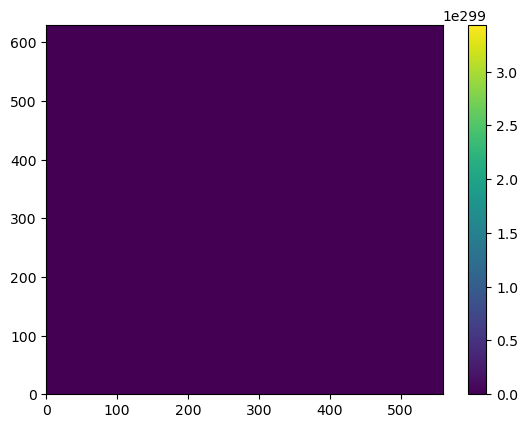

In [205]:
plt.pcolormesh(HADV#,vmin=-1e7,vmax=1e7, cmap='bwr')
# plt.pcolormesh(ma.masked_where(HADV<1e-20,np.zeros(HADV.shape)), cmap='bwr')
plt.colorbar()

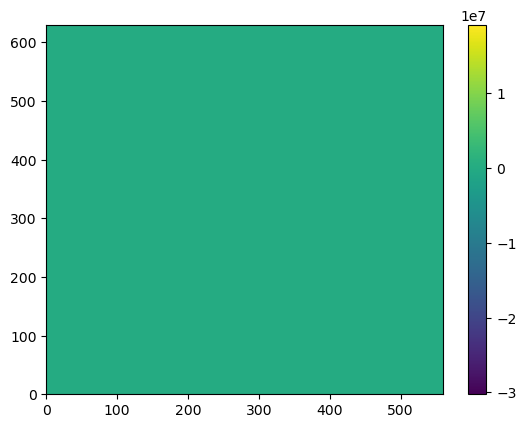

In [206]:
plt.pcolormesh(HUON_VOM_T)#,vmin=-1e7,vmax=1e7, cmap='bwr')
plt.colorbar()

In [46]:
# define cte parameters:

# - based on ROMS def.
# rho0 = 1025 # kg. m-3
# Cp = 3989.245 # J.kg-1.degC-1
# - based opn access-om2 def.
rho0=1035
Cp=3992.1
# Tf = -1.95 # degC
Tf =  -3.534879684448242 # coldest temp along 1500m among all three WAOM expts (10km, 4km, 4km-notide)


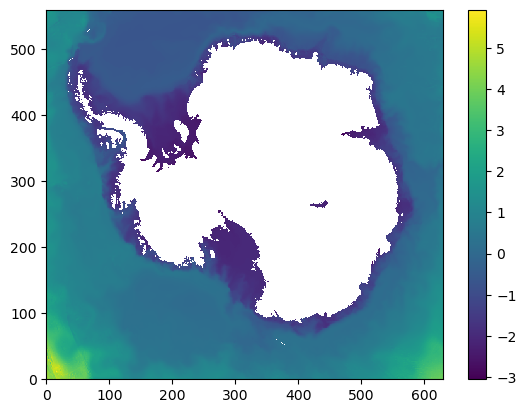

In [47]:
plt.pcolormesh(temp.mean('ocean_time').mean('s_rho'))
plt.colorbar()

In [49]:
dg = xr.open_dataset("/g/data/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_grd.nc")
    
pm = dg.pm
pn = dg.pn

dg.close()


In [52]:
%%time 
# compute m/n, n/m as from roms code (ROMS/Utility/metrics.F)

# !-----------------------------------------------------------------------
# !  Compute m/n, 1/m, and 1/n at horizontal U-points.
# !-----------------------------------------------------------------------
# !
#       DO j=JstrT,JendT
#         DO i=IstrP,IendT
#           pmon_u(i,j)=(pm(i-1,j)+pm(i,j))/(pn(i-1,j)+pn(i,j))
#           pnom_u(i,j)=(pn(i-1,j)+pn(i,j))/(pm(i-1,j)+pm(i,j))
#           om_u(i,j)=2.0_r8/(pm(i-1,j)+pm(i,j))
#           on_u(i,j)=2.0_r8/(pn(i-1,j)+pn(i,j))
#         END DO
#       END DO

# attempt to do it with xarray:
# - follows the order of the eqn in https://www.myroms.org/wiki/Horizontal_Mixing#Horizontal_Diffusion)
# (i.e., derivativates are done in order)

pm_u = pm.rolling({'xi_rho': 2}).mean() # first column is nan (so actual dimension is 629x560
pn_v = pn.rolling({'eta_rho': 2}).mean() # first row is nan (so actual dimension is 630x559

pmon_u = pm_u/pn_v
pnom_v = pn_v/pm_u

pmon_u=pmon_u.rename({'eta_rho': 'eta','xi_rho': 'xi'})
pnom_v=pnom_v.rename({'eta_rho': 'eta','xi_rho': 'xi'})

pmon_u = pmon_u.drop_sel({'xi': pmon_u['xi'][-1]}) # drop last line
pnom_v = pnom_v.drop_sel({'eta': pnom_v['eta'][-1]})

pm_u = pm_u.rename({'eta_rho': 'eta','xi_rho': 'xi'})
pm_u = pm_u.drop_sel({'xi': pm_u['xi'][-1]}) # drop last line

pn_v = pn_v.rename({'eta_rho': 'eta','xi_rho': 'xi'})
pn_v = pn_v.drop_sel({'eta': pn_v['eta'][-1]})

CPU times: user 64.6 ms, sys: 47.3 ms, total: 112 ms
Wall time: 120 ms


In [48]:
%%time
# --- calculate horizontal diffusion term:
#  Dx = (Ni * Hz * pm)/pn * dT/dx
#  Dy = (Ni * Hz * pn)/pm * dT/dy
#

# parameters: pm/pn already load
ni_10km = 50 #m2/s
ni_4km = 20 #m2/s
# ni_2km = 10 #m2/s

# 1st correct temp with Tf and do 1st derivative
temp_Tf = temp# - Tf

# dTdx = temp_Tf.diff('xi_rho',label='lower').rename({'eta_rho': 'eta','xi_rho': 'xi'})
# dTdy = temp_Tf.diff('eta_rho',label='lower').rename({'eta_rho': 'eta','xi_rho': 'xi'})
dTdx = pm_u*temp.diff('xi_rho',label='lower').rename({'eta_rho': 'eta','xi_rho': 'xi'})
dTdy = pn_v*temp.diff('eta_rho',label='lower').rename({'eta_rho': 'eta','xi_rho': 'xi'})

print(dTdx.shape, dTdy.shape)
# dTdx.load()
# dTdy.load()

dTdx = dTdx.transpose('ocean_time','s_rho','eta','xi')
dTdy = dTdy.transpose('ocean_time','s_rho','eta','xi')


(560, 629, 365, 31) (559, 630, 365, 31)
CPU times: user 35.5 ms, sys: 12.3 ms, total: 47.8 ms
Wall time: 43.7 ms


In [49]:
Dz_u = Dz.rolling({'xi_rho': 2}).mean().rename({'eta_rho': 'eta','xi_rho': 'xi','s_w':'s_rho'}) # first row is nan (so actual dimension is 630x559
Dz_v = Dz.rolling({'eta_rho': 2}).mean().rename({'eta_rho': 'eta','xi_rho': 'xi','s_w':'s_rho'}) # first row is nan (so actual dimension is 630x559
 
Dz_u = Dz_u.drop_sel({'xi': Dz_u['xi'][-1]})
Dz_v = Dz_v.drop_sel({'eta': Dz_v['eta'][-1]})


# # replace s_rho in one variable to match:
Dz_u['s_rho'] = dTdx.s_rho
Dz_v['s_rho'] = dTdy.s_rho


In [50]:
%%time
# calculate Hz*dT/dx & Hz*dT/dy
Hzmon_dTdx = np.empty(dTdx.shape)
Hznom_dTdy = np.empty(dTdy.shape)
for tt in range(1):#365): # 1 day all z-levels take ~10-11min
    for kk in range(31):
        Hzmon_dTdx[tt,kk,:] = dTdx.isel(ocean_time=tt, s_rho=kk)*Dz_u.isel(ocean_time=tt, s_rho=kk)*ni_10km*(1/pn)
        Hznom_dTdy[tt,kk,:] = dTdy.isel(ocean_time=tt, s_rho=kk)*Dz_v.isel(ocean_time=tt, s_rho=kk)*ni_10km*(1/pn)


KilledWorker: Attempted to run task ('mul-758adbdf42977a13ba88d984bba9f4f7', 0, 0, 0, 0) on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:40451. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

In [83]:
# convert Hzmon_dTdx/Hznom_dTdy back to DataArray:
new_coords = dTdx.coords
Hzmon_dTdx_da = xr.DataArray(Hzmon_dTdx, dims=dTdx.dims, coords=new_coords)
new_coords = dTdy.coords
Hznom_dTdy_da = xr.DataArray(Hznom_dTdy, dims=dTdx.dims, coords=new_coords)


In [84]:
%%time
## now calculate the 2nd derivative:
dTdx2 = Hzmon_dTdx_da.diff('xi',label='lower')
dTdy2 = Hznom_dTdy_da.diff('eta',label='lower')

# - below not needed, already multiplied by the 1st derivative.
# pmon_u = pmon_u.drop_sel({'xi': pmon_u['xi'][-2]}) # drop last line
# pnom_v = pnom_v.drop_sel({'eta': pmon_u['eta'][-2]})
# Dz_u = Dz_u.drop_sel({'xi': Dz_u['xi'][-2]})
# Dz_v = Dz_v.drop_sel({'eta': Dz_u['eta'][-2]})


CPU times: user 29.8 s, sys: 56.3 s, total: 1min 26s
Wall time: 1min 3s


In [85]:
print(dTdx2.shape, Dz_u.shape, pmon_u.shape)

(365, 31, 560, 628) (365, 31, 560, 629) (560, 629)


In [86]:
%%time
# TRYING TO CHECK IF THE MASK INDEXES HASN'T GONE WRONG:
dTdx_m=(dTdx2*mask_x_transport.isel(xi=slice(0,628))) # here I'm throwing out the 1st and last Xi (x) indexes
dTdy_m=(dTdy2*mask_y_transport.isel(eta=slice(0,558))) # same but for Eta (y) indexes

CPU times: user 27.1 s, sys: 29.9 s, total: 57 s
Wall time: 41.2 s


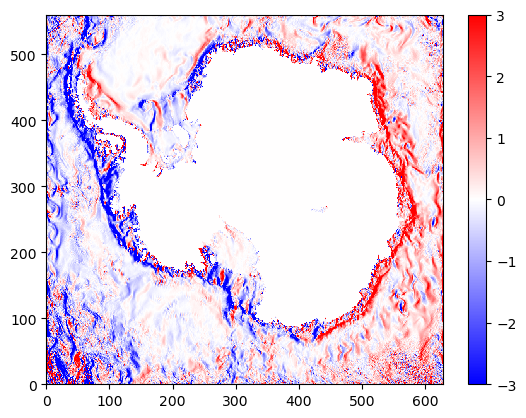

In [87]:
plt.pcolormesh(dTdx.isel(ocean_time=0).sum('s_rho'), vmin=-3, vmax=3, cmap='bwr')
plt.colorbar()

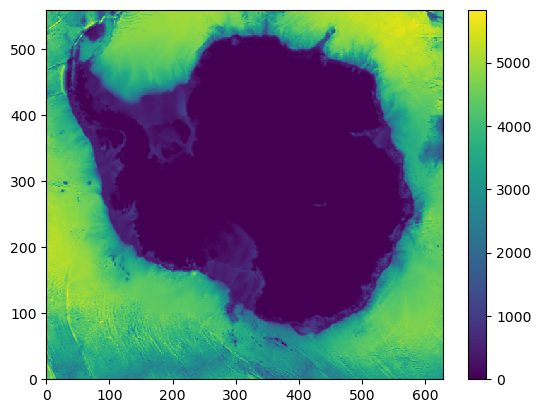

In [88]:
plt.pcolormesh(Dz_u.isel(ocean_time=0).sum('s_rho'))
plt.colorbar()

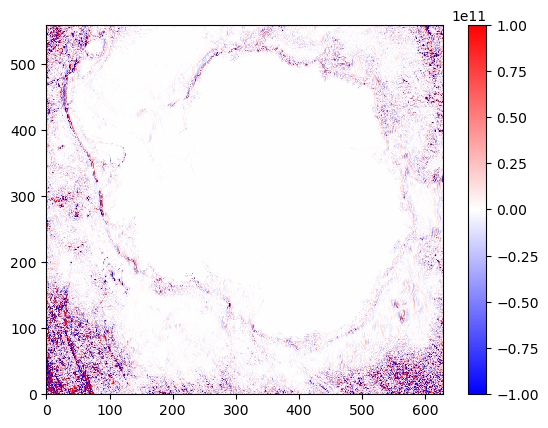

In [90]:

plt.pcolormesh(dTdx2.isel(ocean_time=0).sum('s_rho')*rho0*Cp, vmin=-1e11, vmax=1e11, cmap='bwr')
plt.colorbar()

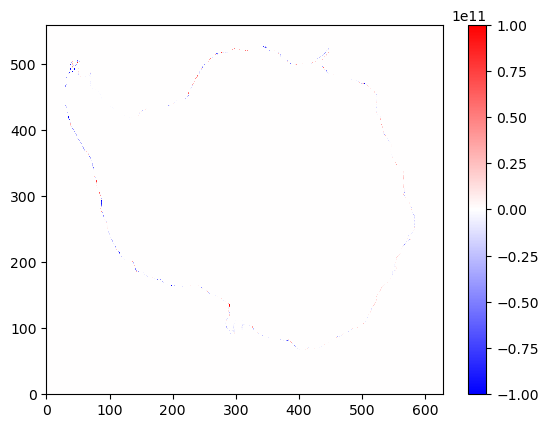

In [91]:
plt.pcolormesh(dTdx_m.isel(ocean_time=0).sum('s_rho')*rho0*Cp, cmap='bwr', vmin=-1e11, vmax=1e11)
plt.colorbar()

In [1]:
plt.pcolormesh(dTdy_m.isel(ocean_time=0).sum('s_rho')*rho0*Cp, cmap='bwr', vmin=-1e11, vmax=1e11)
plt.colorbar()

NameError: name 'plt' is not defined

In [56]:
%%time

## calculate heat transport and subtract Freezing point heat transport:

# 1) multiply rho0*Cp:
HTv = HvomT*rho0*Cp
HTu = HuonT*rho0*Cp

# 2) calculate mean freezing point heat transport: (DONT DO ANNUAL MEAN HERE!!!!)
# VTv_avg = Hvom.mean('ocean_time')
# VTu_avg = Huon.mean('ocean_time')
# HTf_v_avg = VTv_avg*Tf*rho0*Cp
# HTf_u_avg = VTu_avg*Tf*rho0*Cp
HTf_v = Hvom*Tf*rho0*Cp
HTf_u = Huon*Tf*rho0*Cp

# 3) subtract Tf HT from abs HT:
HTv = HTv - HTf_v
HTu = HTu - HTf_u

# 4) rename dimensions before multiplying for mask_x/y_transport:
# convert to DataArray first:
HTv = xr.DataArray(HTv)
HTu = xr.DataArray(HTu)
HTv = HTv.rename({'eta_v': 'eta','xi_v': 'xi'})
HTu = HTu.rename({'eta_u': 'eta','xi_u': 'xi'})

# 4) multiply mask_x/y_transport:
HTvm = HTv*mask_y_transport
HTum = HTu*mask_x_transport

print(HTv.shape, HTu.shape)


(365, 31, 559, 630) (365, 31, 560, 629)
CPU times: user 28.9 ms, sys: 0 ns, total: 28.9 ms
Wall time: 23.4 ms


In [57]:
print(HTvm.shape, HTum.shape)

(365, 31, 559, 630) (365, 31, 560, 629)


In [58]:
    %%time 
    # HTv.load()
    # HTu.load()


CPU times: user 16 µs, sys: 0 ns, total: 16 µs
Wall time: 29.8 µs


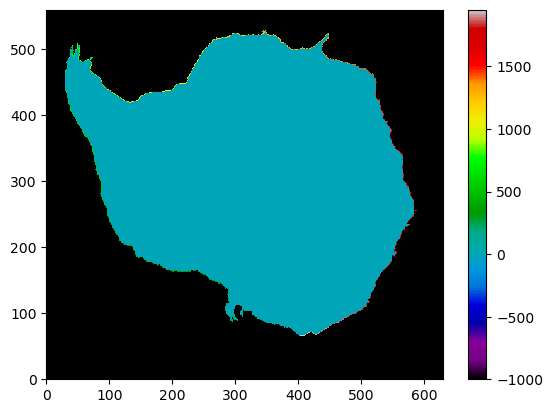

In [59]:
plt.pcolormesh(contour_masked_above, cmap='nipy_spectral')#, vmin=1000, vmax=2700)
plt.colorbar()
# plt.xlim(250,400)
# plt.ylim(0,150)


# create mask for cont. shelf budget:
mask_shelfc = ma.masked_where(contour_masked_above == -1000, np.ones(h.shape))

In [62]:
Net_HT = HTvm.isel(xi=slice(0,629))+HTum.isel(eta=slice(0,559))
Net_HT

NameError: name 'HTvm' is not defined

In [61]:
print(dTdy_m.shape, dTdx_m.shape)

(365, 31, 558, 630) (365, 31, 560, 628)


In [68]:
# combine horz diffusion term:
NetDiff_HT = dTdy_m.isel(xi=slice(1,629))+dTdx_m.isel(eta=slice(1,559))

In [63]:
# load 1500 and calving front contours:
tmp_files_dir = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
expt = 'WAOM10'
ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_1500m')
lon_along_10km_shelf = ds.variables["one"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_1500m')
lat_along_10km_shelf = ds.variables["two"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_CalvingFront')
lon_along_10km_CF = ds.variables["one"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_CalvingFront')
lat_along_10km_CF = ds.variables["two"]
ds.close()

In [57]:
Net_HT.shape

NameError: name 'Net_HT' is not defined

In [1]:
NetDiff_HT.load()

NameError: name 'NetDiff_HT' is not defined

In [67]:
print(dTdx_m.shape, dTdy_m.shape)
print(mask_x_transport.isel(xi=slice(1,629)).shape, mask_y_transport.isel(eta=slice(1,559)).shape)


(365, 31, 560, 628) (365, 31, 558, 630)
(560, 628) (558, 630)


In [ ]:
ct1=plt.scatter(lon_rho[:-2,:-2].values,lat_rho[:-2,:-2].values,c=
                   NetDiff_HT.sum('s_rho').isel(ocean_time=0)*1e-12, s=shape,transform=ccrs.PlateCarree(), cmap='bwr', vmin=-6, vmax=6)


In [ ]:
# call cartopy projection
proj = ccrs.PlateCarree(central_longitude=-24)
fig = plt.figure(figsize=(12,10))

# Original WAOM10
# ax1 = fig.add_subplot(211, projection=proj)
# ct1=plt.scatter(lon_rho[:-1,:-1].values,lat_rho[:-1,:-1].values,c=
#                    Net_HT.sum('s_rho').mean('ocean_time')*1e-12, s=shape,transform=ccrs.PlateCarree(), cmap='bwr', vmin=-6, vmax=6)

# # plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
# # plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
# plt.title('WAOM10 - Horizontal advection of heat')

# ax1.gridlines(draw_labels=True,linewidth=.1)
# ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
# # plt.colorbar(ct1, location="right")
# ax1.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
# x_left, x_right = ax1.get_xlim()
# y_low, y_high = ax1.get_ylim()
# ratio = .3
# ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
# plt.colorbar(ct1)
# cbar_ax0 = fig.add_axes([0.48, 0.695, 0.01, 0.135])
# fig.colorbar(ct1, cax=cbar_ax0, orientation='vertical')
# cbar_ax0.set_ylabel('Cross-1500m HT (TW) ')#, labelpad=-35)


# Original WAOM10
ax2 = fig.add_subplot(212, projection=proj)
ct1=plt.scatter(lon_rho[:-2,:-2].values,lat_rho[:-2,:-2].values,c=
                   NetDiff_HT.sum('s_rho').mean('ocean_time')*1e-12, s=shape,transform=ccrs.PlateCarree(), cmap='bwr', vmin=-6, vmax=6)

# plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
# plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10 - Horizontal diffusion of heat')

ax2.gridlines(draw_labels=True,linewidth=.1)
ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
# plt.colorbar(ct1, location="right")
ax2.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ratio = .3
ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
plt.colorbar(ct1)

2024-06-27 12:55:32,820 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:46215 -> tcp://127.0.0.1:34855
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/worker.py", line 1783, in get_data
    response = await comm.read(deserializers=serializers)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/comm/

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize = (12, 8))

ymin=0
ymax=300
xmin=0
xmax=300

cc=axs[0,0].pcolormesh(HTv.sum('s_rho').mean('ocean_time').values*mask_shelfc[:-1,:]*1e-12,  vmin=-2, vmax=2, cmap='bwr')
axs[0,0].set_title('HT v')

axs[0,1].pcolormesh(HTvm.sum('s_rho').mean('ocean_time')*1e-12, vmin=-2, vmax=2, cmap='bwr')
axs[0,1].set_title('HT v*mask_y_transp')

axs[1,0].pcolormesh(HTu.sum('s_rho').mean('ocean_time').values*mask_shelfc[:,:-1]*1e-12, vmin=-2, vmax=2, cmap='bwr')
axs[1,0].set_title('HT u')

axs[1,1].pcolormesh(HTum.sum('s_rho').mean('ocean_time')*1e-12, vmin=-2, vmax=2, cmap='bwr')
axs[1,1].set_title('HT u*mask_x_transp')

plt.colorbar(cc)

axs[0,0].set_ylim(ymin,ymax)
axs[0,0].set_xlim(xmin,xmax)
axs[0,1].set_ylim(ymin,ymax)
axs[0,1].set_xlim(xmin,xmax)
axs[1,0].set_ylim(ymin,ymax)
axs[1,0].set_xlim(xmin,xmax)
axs[1,1].set_ylim(ymin,ymax)
axs[1,1].set_xlim(xmin,xmax)

(300.0, 600.0)

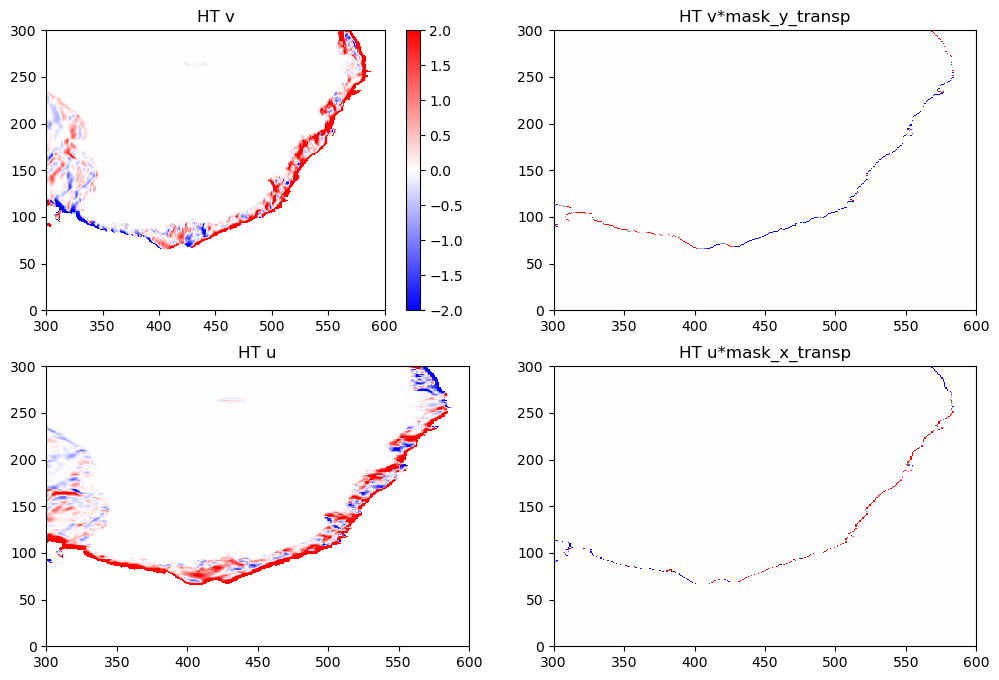

In [72]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize = (12, 8))

ymin=0
ymax=300
xmin=300
xmax=600

cc=axs[0,0].pcolormesh(HTv.sum('s_rho').mean('ocean_time').values*mask_shelfc[:-1,:]*1e-12,  vmin=-2, vmax=2, cmap='bwr')
axs[0,0].set_title('HT v')

axs[0,1].pcolormesh(HTvm.sum('s_rho').mean('ocean_time')*1e-12, vmin=-2, vmax=2, cmap='bwr')
axs[0,1].set_title('HT v*mask_y_transp')

axs[1,0].pcolormesh(HTu.sum('s_rho').mean('ocean_time').values*mask_shelfc[:,:-1]*1e-12, vmin=-2, vmax=2, cmap='bwr')
axs[1,0].set_title('HT u')

axs[1,1].pcolormesh(HTum.sum('s_rho').mean('ocean_time')*1e-12, vmin=-2, vmax=2, cmap='bwr')
axs[1,1].set_title('HT u*mask_x_transp')
plt.colorbar(cc)

axs[0,0].set_ylim(ymin,ymax)
axs[0,0].set_xlim(xmin,xmax)
axs[0,1].set_ylim(ymin,ymax)
axs[0,1].set_xlim(xmin,xmax)
axs[1,0].set_ylim(ymin,ymax)
axs[1,0].set_xlim(xmin,xmax)
axs[1,1].set_ylim(ymin,ymax)
axs[1,1].set_xlim(xmin,xmax)

(0.0, 300.0)

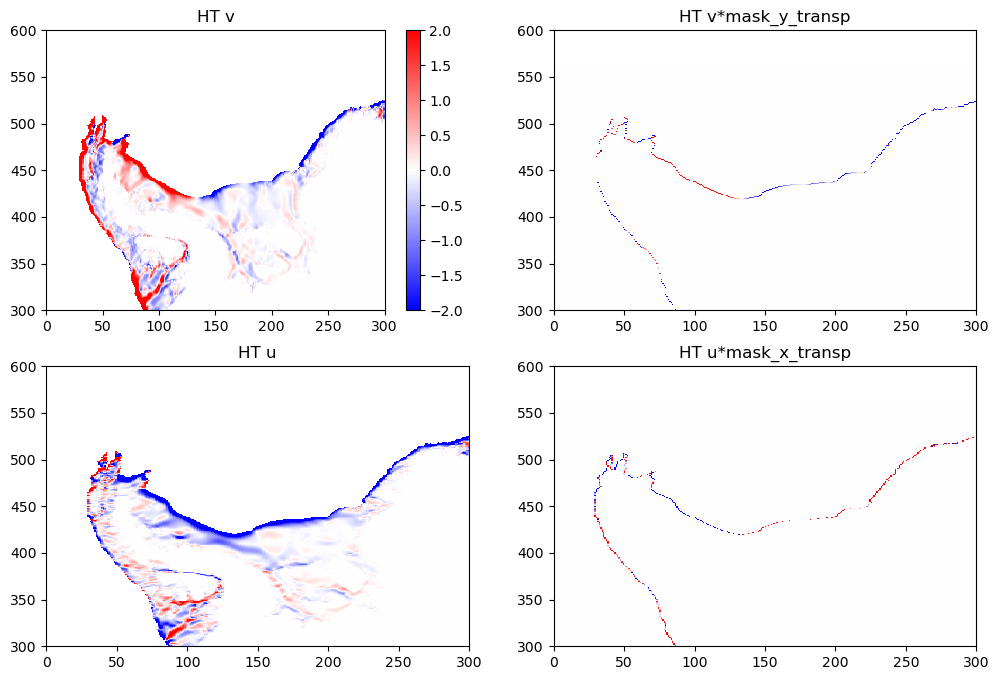

In [73]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize = (12, 8))

ymin=300
ymax=600
xmin=0
xmax=300

cc=axs[0,0].pcolormesh(HTv.sum('s_rho').mean('ocean_time').values*mask_shelfc[:-1,:]*1e-12,  vmin=-2, vmax=2, cmap='bwr')
axs[0,0].set_title('HT v')

axs[0,1].pcolormesh(HTvm.sum('s_rho').mean('ocean_time')*1e-12, vmin=-2, vmax=2, cmap='bwr')
axs[0,1].set_title('HT v*mask_y_transp')

axs[1,0].pcolormesh(HTu.sum('s_rho').mean('ocean_time').values*mask_shelfc[:,:-1]*1e-12, vmin=-2, vmax=2, cmap='bwr')
axs[1,0].set_title('HT u')

axs[1,1].pcolormesh(HTum.sum('s_rho').mean('ocean_time')*1e-12, vmin=-2, vmax=2, cmap='bwr')
axs[1,1].set_title('HT u*mask_x_transp')
plt.colorbar(cc)


axs[0,0].set_ylim(ymin,ymax)
axs[0,0].set_xlim(xmin,xmax)
axs[0,1].set_ylim(ymin,ymax)
axs[0,1].set_xlim(xmin,xmax)
axs[1,0].set_ylim(ymin,ymax)
axs[1,0].set_xlim(xmin,xmax)
axs[1,1].set_ylim(ymin,ymax)
axs[1,1].set_xlim(xmin,xmax)

(300.0, 600.0)

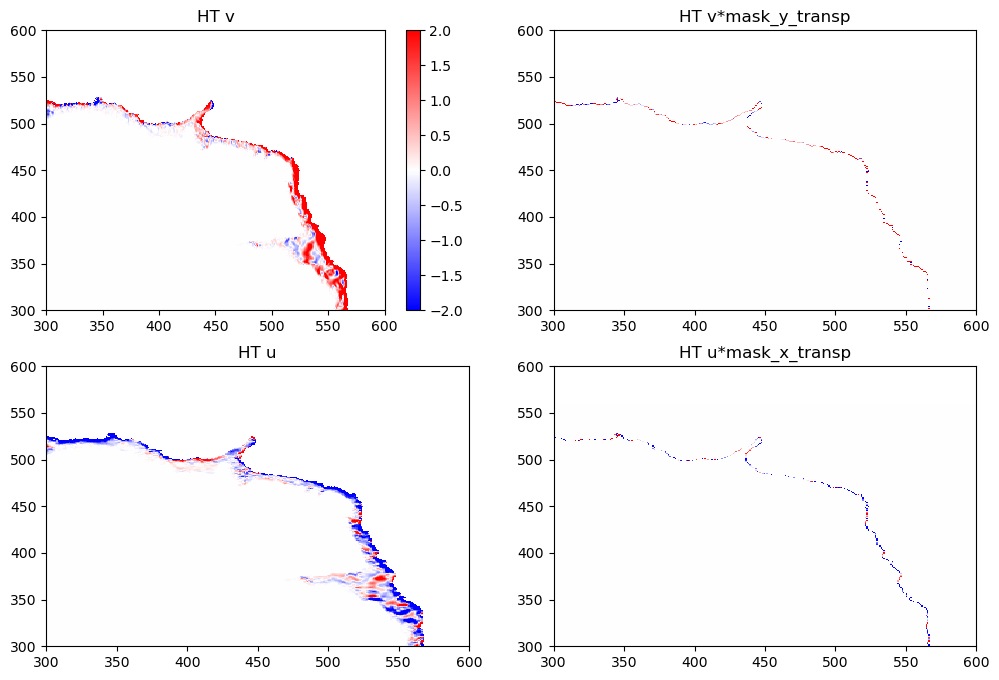

In [74]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize = (12, 8))

ymin=300
ymax=600
xmin=300
xmax=600

cc=axs[0,0].pcolormesh(HTv.sum('s_rho').mean('ocean_time').values*mask_shelfc[:-1,:]*1e-12,  vmin=-2, vmax=2, cmap='bwr')
axs[0,0].set_title('HT v')

axs[0,1].pcolormesh(HTvm.sum('s_rho').mean('ocean_time')*1e-12, vmin=-2, vmax=2, cmap='bwr')
axs[0,1].set_title('HT v*mask_y_transp')

axs[1,0].pcolormesh(HTu.sum('s_rho').mean('ocean_time').values*mask_shelfc[:,:-1]*1e-12, vmin=-2, vmax=2, cmap='bwr')
axs[1,0].set_title('HT u')

axs[1,1].pcolormesh(HTum.sum('s_rho').mean('ocean_time')*1e-12, vmin=-2, vmax=2, cmap='bwr')
axs[1,1].set_title('HT u*mask_x_transp')
plt.colorbar(cc)


axs[0,0].set_ylim(ymin,ymax)
axs[0,0].set_xlim(xmin,xmax)
axs[0,1].set_ylim(ymin,ymax)
axs[0,1].set_xlim(xmin,xmax)
axs[1,0].set_ylim(ymin,ymax)
axs[1,0].set_xlim(xmin,xmax)
axs[1,1].set_ylim(ymin,ymax)
axs[1,1].set_xlim(xmin,xmax)

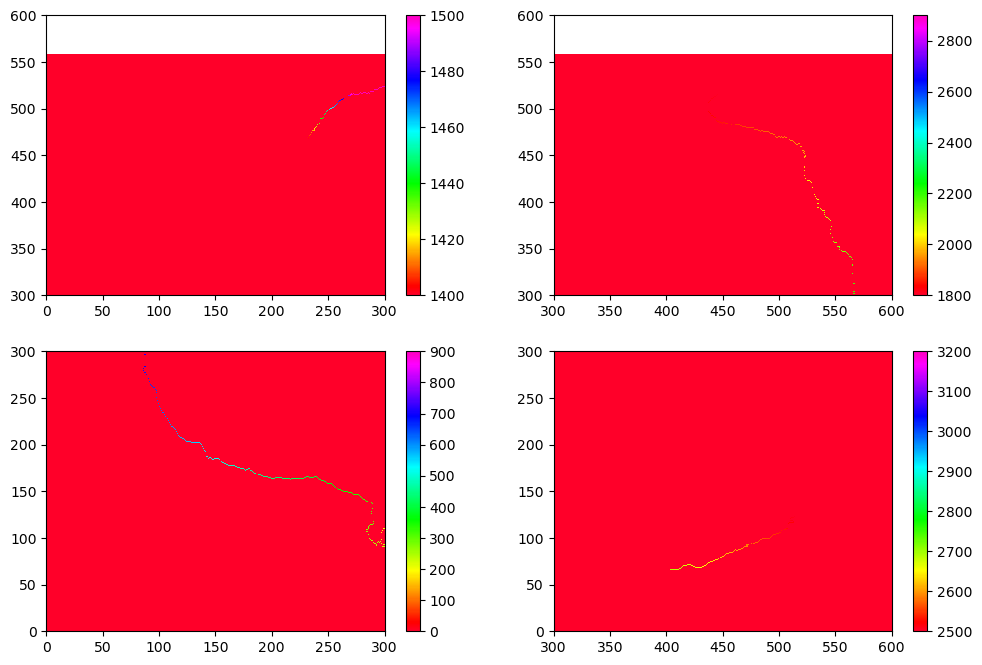

In [75]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize = (12, 8))

cc=axs[1,0].pcolormesh(mask_y_transport_numbered, cmap='gist_rainbow', vmin=0 , vmax=900 ) #
axs[1,0].set_ylim(0,300)
axs[1,0].set_xlim(0,300)
plt.colorbar(cc)

cc=axs[1,1].pcolormesh(mask_y_transport_numbered, cmap='gist_rainbow', vmin=2500 , vmax=3200 )
axs[1,1].set_ylim(0,300)
axs[1,1].set_xlim(300,600)
plt.colorbar(cc)

cc=axs[0,0].pcolormesh(mask_y_transport_numbered, cmap='gist_rainbow', vmin=1400 , vmax=1500 ) #, vmin=900 , vmax=2000 )
axs[0,0].set_ylim(300,600)
axs[0,0].set_xlim(0,300)
plt.colorbar(cc)

cc=axs[0,1].pcolormesh(mask_y_transport_numbered, cmap='gist_rainbow', vmin=1800 , vmax=2900 )
axs[0,1].set_ylim(300,600)
axs[0,1].set_xlim(300,600)
plt.colorbar(cc)


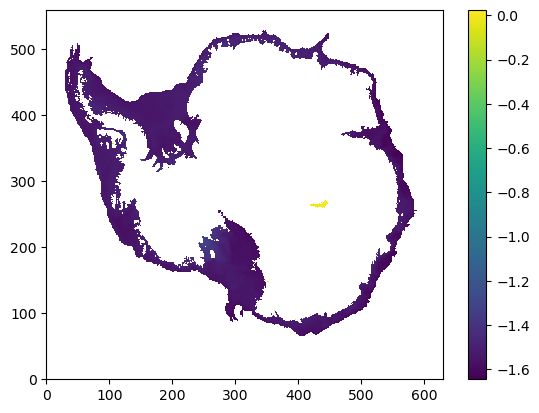

In [76]:
plt.pcolormesh(ssh.mean('ocean_time').values*mask_shelfc)#, vmin=650, vmax=850)
plt.colorbar()
# plt.xlim(250,400

In [77]:
ssh_annual = ssh.mean('ocean_time').values*mask_shelfc
print(ssh_annual.shape)
ssh_ts = ssh.values*mask_shelfc
ssh_sum = np.nansum(np.nansum(ssh_annual, axis=1), axis=0)
ssh_avg = np.nanmean(np.nanmean(ssh_annual, axis=1), axis=0)
ssh_avg_ts = np.nanmean(np.nanmean(ssh_ts, axis=2), axis=1)

(560, 630)


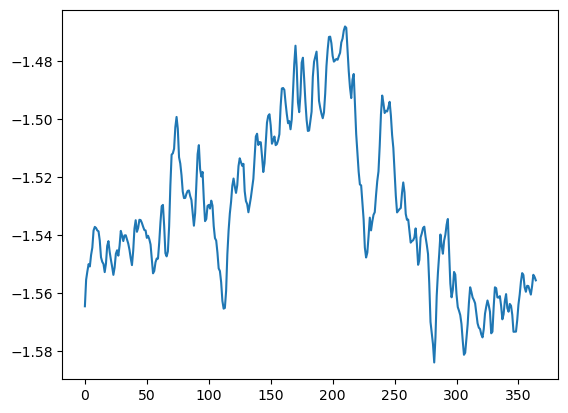

In [78]:
plt.plot(ssh_avg_ts)#, vmin=650, vmax=850)


ssh averaged over the shelf (using same mask from the contour) looks ok (i.e. not increasing in a way that ~20Sv are going southward); 10cm of seasonal variation

In [79]:
# convert temp to DataArray to extract values along contour:
months=np.arange(0,365)*(1/30.41667)

# Convert heat transport to data arrays:
coordinates3Du = dict(ocean_time=months, s_rho=(['s_rho'], np.arange(0,31)),
                    eta_u=(['eta_u'], np.arange(0,560)), xi_u=(['xi_u'], np.arange(0,629)))
coordinates3Dv = dict(ocean_time=months, s_rho=(['s_rho'], np.arange(0,31)),
                    eta_v=(['eta_v'], np.arange(0,559)), xi_v=(['xi_v'], np.arange(0,630)))

# - handling x/y transports (Hvom, Huon [m3.s-1]) to calculate heat transport
Huon_xr = xr.DataArray(Huon, coords = coordinates3Du, dims = ['ocean_time','s_rho','eta_u', 'xi_u'])
Hvom_xr = xr.DataArray(Hvom, coords = coordinates3Dv, dims = ['ocean_time','s_rho','eta_v', 'xi_v'])

# rename dimensions as simply eta/xi
Huon_xr = Huon_xr.rename({'eta_u': 'eta','xi_u': 'xi'})
Hvom_xr = Hvom_xr.rename({'eta_v': 'eta','xi_v': 'xi'})


In [80]:
print(HTu.shape)

(365, 31, 560, 629)


In [81]:
# %%time
# # new version mimicing access-om2-01 script CSHT_IAF_non_paralelized.ipynb:

# # keep daily data:

# def extract_transp_across_contour(var_x, var_y):   # var:4D [time,eta_rho,xi_rho]
#     tlen = len(HTu[:,0,0,0])
#     zlen = len(HTu[0,:,0,0])
#     print(zlen)
#     heat_transp_across_contour = np.empty((tlen,zlen,len(contour_ordering)))

#     for tt in range(0,tlen):
#     # tt=0
#         for zz in range(0,zlen): # loop through z-levels
#             # 1st: stack mask_x/y_transport
#             x_along_1d = mask_x_transport.stack(contour_index = ['eta', 'xi'])
#             x_along_1d = x_along_1d.where(mask_x_numbered_1d>0, drop = True)
#             y_along_1d = mask_y_transport.stack(contour_index = ['eta', 'xi'])
#             y_along_1d = y_along_1d.where(mask_y_numbered_1d>0, drop = True)
    	
#             # combine all points on contour, to obtain a matrix with transport directions:
#             transp_dir = xr.concat((x_along_1d, y_along_1d), dim = 'contour_index')
#             transp_dir = transp_dir.sortby(contour_ordering)
#             transp_dir.coords['contour_index'] = contour_index_array
#             transp_dir = transp_dir.load()
                
#             var_x_tmp = var_x[tt,zz,:,:]
#             var_y_tmp = var_y[tt,zz,:,:]
    
#             # stack transports into 1d and drop any points not on contour:
#             x_var_1d_tmp = var_x_tmp.stack(contour_index = ['eta', 'xi'])
#             x_var_1d_tmp = x_var_1d_tmp.where(mask_x_numbered_1d>0, drop = True)
#             y_var_1d_tmp = var_y_tmp.stack(contour_index = ['eta', 'xi'])
#             y_var_1d_tmp = y_var_1d_tmp.where(mask_y_numbered_1d>0, drop = True)
    
#             # combine all points on contour:
#             heat_transp_across_contour_tmp = xr.concat((x_var_1d_tmp, y_var_1d_tmp), dim = 'contour_index')
#             heat_transp_across_contour_tmp = heat_transp_across_contour_tmp.sortby(contour_ordering)
#             heat_transp_across_contour_tmp.coords['contour_index'] = contour_index_array
#             heat_transp_across_contour_tmp = (heat_transp_across_contour_tmp*transp_dir).load()
            
#             print(zz, heat_transp_across_contour.shape)
#             heat_transp_across_contour[tt,zz,:] = heat_transp_across_contour_tmp
#             del heat_transp_across_contour_tmp
        
#     return heat_transp_across_contour

# # extract variables:
# # heat transport
# # heat_trans_across_contour = extract_transp_across_contour(HTu, HTv)


In [94]:
contour_ordering

<xarray.DataArray (contour_index: 2690)> Size: 22kB
array([1.000e+00, 2.000e+00, 3.000e+00, ..., 2.688e+03, 2.689e+03,
       2.690e+03])
Coordinates:
    one            (contour_index) float64 22kB 156.3 156.5 ... 155.8 156.0
    two            (contour_index) float64 22kB -66.88 -66.91 ... -66.81 -66.84
    contour_index  (contour_index) object 22kB MultiIndex
    eta            (contour_index) int64 22kB 66 66 67 67 67 ... 66 66 66 66 66
    xi             (contour_index) int64 22kB 402 401 400 400 ... 405 404 403

In [101]:
# plt.pcolormesh(mask_y_transport_numbered)
# plt.colorbar()
np.max(mask_y_transport_numbered)

<xarray.DataArray ()> Size: 8B
array(2690.)

In [82]:
%%time
## repeat for annual mean to check with Claire's example:

# defin function to extract any 4D var along the contour line

def extract_transp_across_contour_tavg(var_x, var_y):   # var:4D [time,eta_rho,xi_rho]

    zlen = len(temp[0,:,0,0])
    print(zlen)
    transp_across_contour = np.empty((zlen,len(contour_ordering)))

    for zz in range(0,zlen): # loop through z-levels
 
        # var_x_tmp = var_x[zz,:,:]*mask_x_transport[:,:-1] # the bug fixed in the -40Sv Vol transport came from here;
        # var_y_tmp = var_y[zz,:,:]*mask_y_transport[:-1,:] # the mask_x/y_transport are thought based on the staggeering grid alreadry
                                                          # (double-check for converting from B-Grid to C-Grid [Fabio, Mar24])   
                                                          # so the interpol. to u/v grid (done before) weren't necessary; they actually
                                                          # messed up the fluxes in a way that the circum-Ant. integral weren't Zero.
        var_x_tmp = var_x[zz,:,:]
        var_y_tmp = var_y[zz,:,:]

        
        # stack transports into 1d and drop any points not on contour:
        x_var_1d_tmp = var_x_tmp.stack(contour_index = ['eta', 'xi'])
        x_var_1d_tmp = x_var_1d_tmp.where(mask_x_numbered_1d>0, drop = True)
        y_var_1d_tmp = var_y_tmp.stack(contour_index = ['eta', 'xi'])
        y_var_1d_tmp = y_var_1d_tmp.where(mask_y_numbered_1d>0, drop = True)

        # combine all points on contour:
        transp_across_contour_tmp = xr.concat((x_var_1d_tmp, y_var_1d_tmp), dim = 'contour_index')
        transp_across_contour_tmp = transp_across_contour_tmp.reset_index('contour_index') # added by fabio, otherwise it crashes due to duplicated indices
        transp_across_contour_tmp = transp_across_contour_tmp.sortby(contour_ordering)
        transp_across_contour_tmp.coords['contour_index'] = contour_index_array
        transp_across_contour_tmp = transp_across_contour_tmp.load()

        print(zz, transp_across_contour_tmp.shape)
        transp_across_contour[zz,:] = transp_across_contour_tmp
        del transp_across_contour_tmp

    return transp_across_contour

# extract variables:

# new attempt by calculating HvomT/HuonT -  Tf HT before extracting transport along contour:
heat_trans_across_contour_tavg = extract_transp_across_contour_tavg(HTum.mean('ocean_time'), HTvm.mean('ocean_time'))
  

31
0 (2690,)
1 (2690,)
2 (2690,)
3 (2690,)
4 (2690,)
5 (2690,)
6 (2690,)
7 (2690,)
8 (2690,)
9 (2690,)
10 (2690,)
11 (2690,)
12 (2690,)
13 (2690,)
14 (2690,)
15 (2690,)
16 (2690,)
17 (2690,)
18 (2690,)
19 (2690,)
20 (2690,)
21 (2690,)
22 (2690,)
23 (2690,)
24 (2690,)
25 (2690,)
26 (2690,)
27 (2690,)
28 (2690,)
29 (2690,)
30 (2690,)
CPU times: user 6min 4s, sys: 1min 11s, total: 7min 15s
Wall time: 16min 31s


In [83]:
heat_trans_across_contour_tavg.shape

(31, 2690)

(-500000000000000.0, 500000000000000.0)

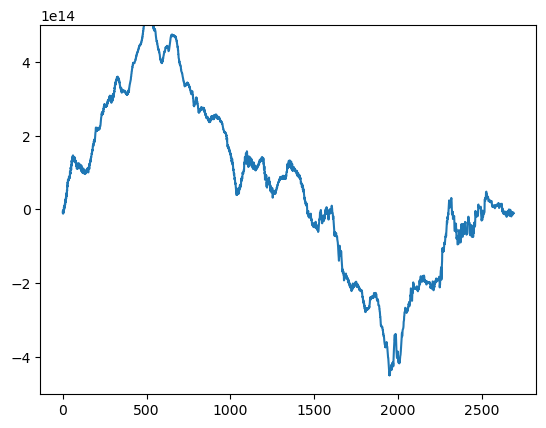

In [84]:
plt.plot(np.cumsum(np.sum(heat_trans_across_contour_tavg, axis=0)))
plt.ylim(-5e14,5e14)

(-500000000000000.0, 500000000000000.0)

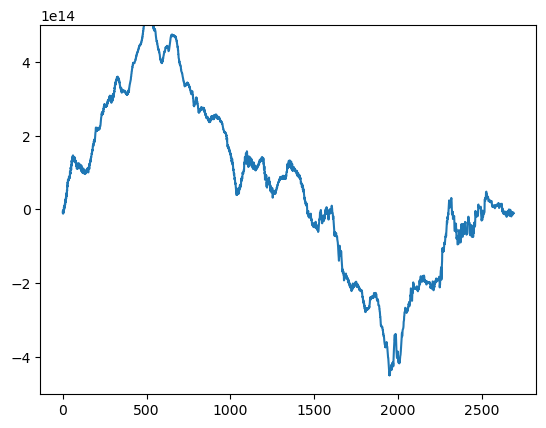

In [85]:
# plt.plot(np.cumsum(np.sum(np.nanmean(heat_trans_across_contour, axis=0), axis=0)))
plt.plot(np.cumsum(np.sum(heat_trans_across_contour_tavg, axis=0)))
plt.ylim(-5e14,5e14)

In [86]:
def extract_tracer_along_contour_tavg(var):   # var:4D [time,eta_rho,xi_rho]

    zlen = len(temp[0,:,0,0])
    print(zlen)
    tracer_along_contour = np.empty((zlen,len(contour_ordering)))

    for zz in range(0,zlen): # loop through z-levels
 
        var_tmp = var[zz,:,:]
        
        # stack transports into 1d and drop any points not on contour:
        x_var_1d_tmp = var_tmp.stack(contour_index = ['eta', 'xi'])
        x_var_1d_tmp = x_var_1d_tmp.where(mask_x_numbered_1d>0, drop = True)
        y_var_1d_tmp = var_tmp.stack(contour_index = ['eta', 'xi'])
        y_var_1d_tmp = y_var_1d_tmp.where(mask_y_numbered_1d>0, drop = True)

        # combine all points on contour:
        tracer_along_contour_tmp = xr.concat((x_var_1d_tmp, y_var_1d_tmp), dim = 'contour_index')
        tracer_along_contour_tmp = tracer_along_contour_tmp.reset_index('contour_index') # added by fabio, otherwise it crashes due to duplicated indices
        tracer_along_contour_tmp = tracer_along_contour_tmp.sortby(contour_ordering)
        tracer_along_contour_tmp.coords['contour_index'] = contour_index_array
        tracer_along_contour_tmp = tracer_along_contour_tmp.load()

        print(zz, tracer_along_contour_tmp.shape)
        tracer_along_contour[zz,:] = tracer_along_contour_tmp
        del tracer_along_contour_tmp

    return tracer_along_contour

# convert temp to DataArray to extract values along contour:
months=np.arange(0,365)*(1/30.41667)
coordinatesT=dict(ocean_time=months, s_rho=(['s_rho'], np.arange(0,31)),
                    eta_rho=(['eta_rho'], np.arange(0,560)), xi_rho=(['xi_rho'], np.arange(0,630)))
temp_xr = xr.DataArray(temp, coords = coordinatesT, dims = ['ocean_time','s_rho','eta_rho', 'xi_rho'])
# rename dimensions as simply eta/xi
temp_xr = temp_xr.rename({'eta_rho': 'eta','xi_rho': 'xi'})

# extract variables:
temp_along_contour_tavg = extract_tracer_along_contour_tavg(temp_xr.mean('ocean_time'))



31
0 (2690,)
1 (2690,)
2 (2690,)
3 (2690,)
4 (2690,)
5 (2690,)
6 (2690,)
7 (2690,)
8 (2690,)
9 (2690,)
10 (2690,)
11 (2690,)
12 (2690,)
13 (2690,)
14 (2690,)
15 (2690,)
16 (2690,)
17 (2690,)
18 (2690,)
19 (2690,)
20 (2690,)
21 (2690,)
22 (2690,)
23 (2690,)
24 (2690,)
25 (2690,)
26 (2690,)
27 (2690,)
28 (2690,)
29 (2690,)
30 (2690,)


In [87]:
vol_trans_across_contour_tavg = extract_transp_across_contour_tavg(Huon_xr.mean('ocean_time')*mask_x_transport, Hvom_xr.mean('ocean_time')*mask_y_transport)


31
0 (2690,)
1 (2690,)
2 (2690,)
3 (2690,)
4 (2690,)
5 (2690,)
6 (2690,)
7 (2690,)
8 (2690,)
9 (2690,)
10 (2690,)
11 (2690,)
12 (2690,)
13 (2690,)
14 (2690,)
15 (2690,)
16 (2690,)
17 (2690,)
18 (2690,)
19 (2690,)
20 (2690,)
21 (2690,)
22 (2690,)
23 (2690,)
24 (2690,)
25 (2690,)
26 (2690,)
27 (2690,)
28 (2690,)
29 (2690,)
30 (2690,)


In [88]:
# define dist and z coordinates for pcolormesh plot:
expt='WAOM10'
tmp_files_dir = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
ds = xr.open_dataset(tmp_files_dir + expt + '_dist_along_1500m_v3')
dist_along_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_z_rho_1500m_daily_v3')
z_rho_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_dist_indices_1500m_v3')
distance_indices_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

[dist_along_axis_10km, Zaxis_10km] = np.meshgrid(dist_along_10km, np.arange(0,31))


In [89]:
# np.cumsum(np.sum(vol_trans_across_contour_tavg, axis=0), axis=0)[0]*1e-6   # m3/s * 86400*365

# np.nanmax(np.nanmean(temp_along_contour_tavg,axis=0),axis=0)


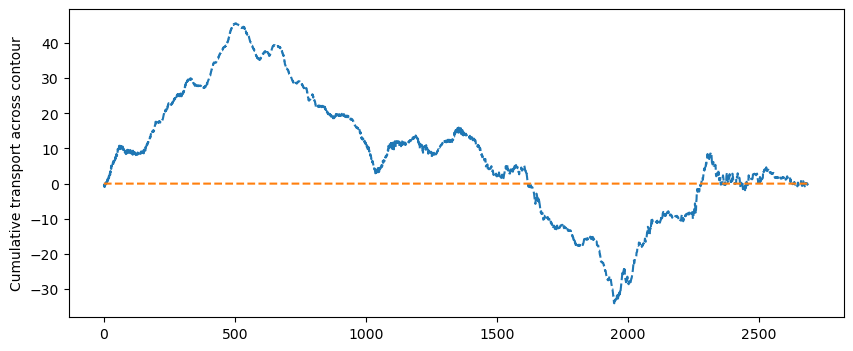

In [90]:
# plot Volume transport:

fig, ax = plt.subplots(figsize = (10, 4))

# plt.plot(np.cumsum(np.sum(np.nanmean(vol_trans_across_contour, axis=0), axis=0), axis=0))
plt.plot(np.cumsum(np.sum(vol_trans_across_contour_tavg, axis=0), axis=0)*1e-6,'--')
# plt.plot(np.sum(vol_trans_across_contour_tavg, axis=0),'--')
plt.plot(np.zeros(len(vol_trans_across_contour_tavg[0,:])),'--')
ax.set_ylabel('Cumulative transport across contour');


In [91]:
# calculate Tf heat transport
Tf_heat_transport = vol_trans_across_contour_tavg*Tf*rho0*Cp

# calculate mean eddy
mean_ht = vol_trans_across_contour_tavg*(temp_along_contour_tavg-Tf)*rho0*Cp

print(mean_ht.shape, heat_trans_across_contour_tavg.shape)


(31, 2690) (31, 2690)


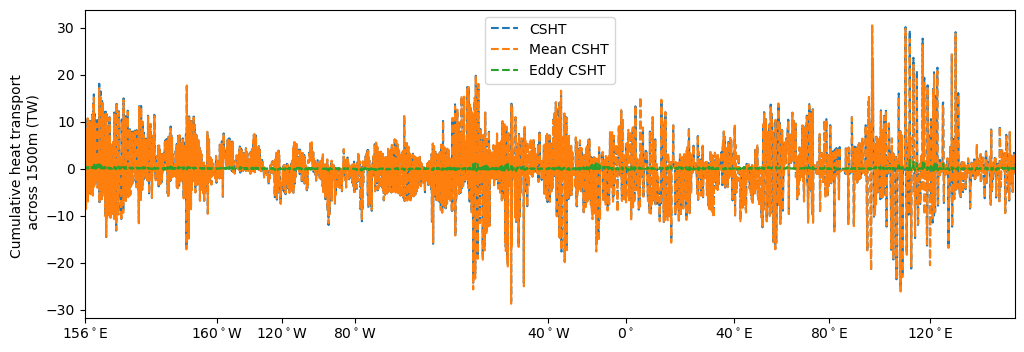

In [92]:
fig_path = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/'

fig, ax = plt.subplots(figsize = (12, 4))
plt.plot(dist_along_10km,np.divide(np.sum(heat_trans_across_contour_tavg, axis=0),1)*1e-12,'--', label='CSHT') # divide by 1000
plt.plot(dist_along_10km,np.divide(np.sum(mean_ht, axis=0),1)*1e-12,'--', label='Mean CSHT')
# plt.plot(dist_along_10km,-np.divide(np.sum(Tf_heat_transport, axis=0),1)*1e-12,'--',label='Tf HT x(-1)')
plt.plot(dist_along_10km,np.divide(np.sum(heat_trans_across_contour_tavg-mean_ht, axis=0),1)*1e-12,'--', label='Eddy CSHT')

ax.set_ylabel('Cumulative heat transport \n across 1500m (TW)');
plt.legend()
# plt.ylim(-500,2500)

ax.set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                           '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax.set_xlim(0, dist_along_10km[-1])
# ax.set_aspect('auto')
ax.tick_params(labelsize=10)

plt.savefig(fig_path + 'WAOM10_Cross-1500m_vint_NonCumsum_MeanEddy_v4.png', bbox_inches='tight', dpi=300)
plt.show()

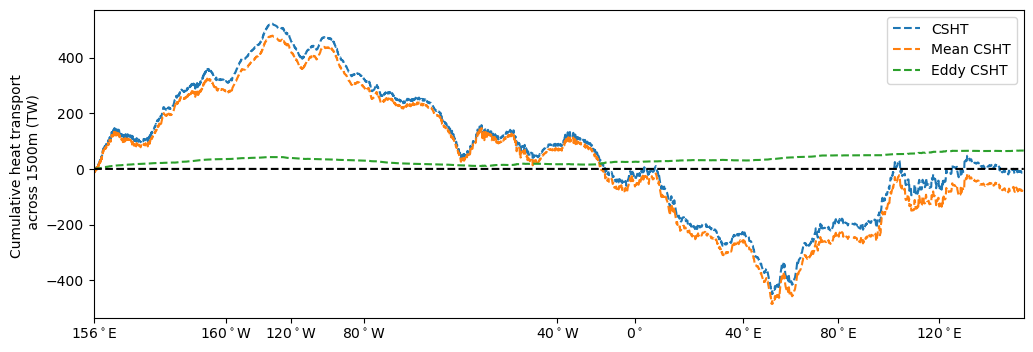

In [93]:

fig, ax = plt.subplots(figsize = (12, 4))

plt.plot(dist_along_10km,np.cumsum(np.divide(np.sum(heat_trans_across_contour_tavg, axis=0),1), axis=0)*1e-12,'--', label='CSHT')
plt.plot(dist_along_10km,np.cumsum(np.divide(np.sum(mean_ht, axis=0),1), axis=0)*1e-12,'--', label='Mean CSHT')
# plt.plot(dist_along_10km,-np.cumsum(np.divide(np.sum(Tf_heat_transport, axis=0),1), axis=0)*1e-12,'--',label='Tf HT x(-1)')
plt.plot(dist_along_10km,np.cumsum(np.divide(np.sum(heat_trans_across_contour_tavg-mean_ht, axis=0),1), axis=0)*1e-12,'--', label='Eddy CSHT')
plt.plot(dist_along_10km,np.sum(mean_ht, axis=0)*0,'--k')
ax.set_ylabel('Cumulative heat transport \n across 1500m (TW)');
plt.legend()
# plt.ylim(-500,2500)

ax.set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                           '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax.set_xlim(0, dist_along_10km[-1])
# ax.set_aspect('auto')
ax.tick_params(labelsize=10)

plt.savefig(fig_path + 'WAOM10_Cross-1500m_vint_MeanEddy_Tf_v4.png', bbox_inches='tight', dpi=300)
plt.show()

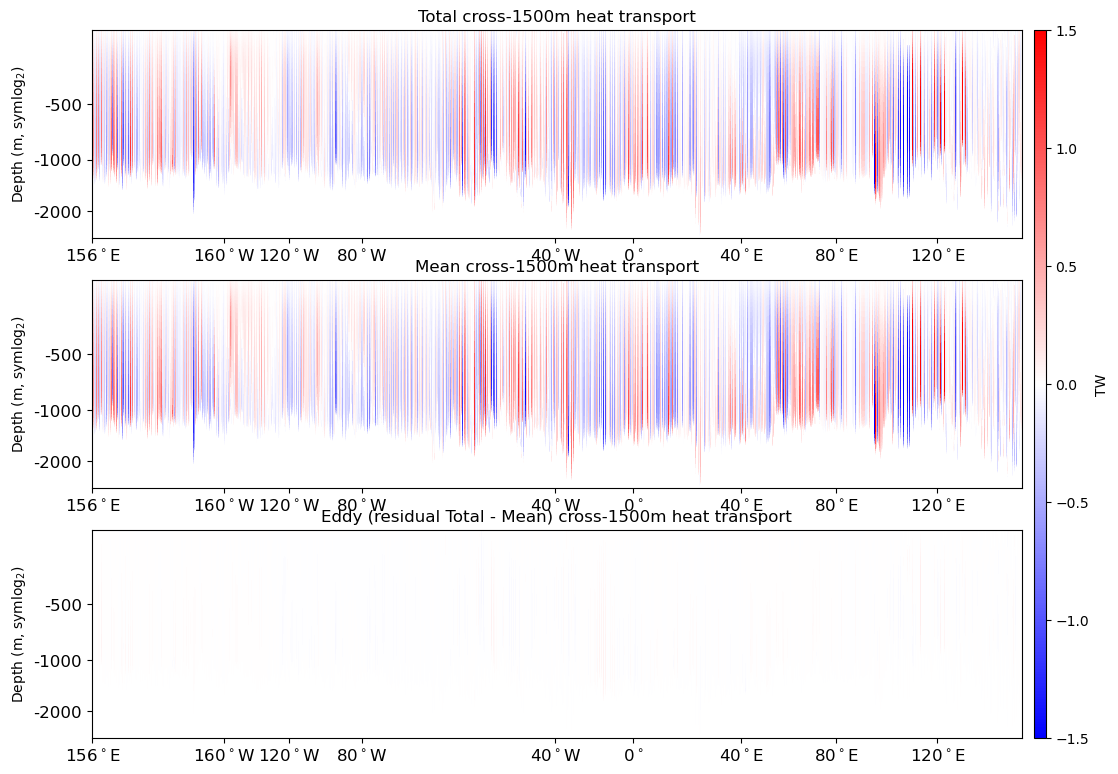

In [102]:

# fig, ax = plt.subplots(figsize = (9, 3))
fig, axs = plt.subplots(nrows=3, figsize = (12, 9.2))

axs[0].pcolormesh(dist_along_axis_10km, np.nanmean(z_rho_10km, axis=0),heat_trans_across_contour_tavg*1e-12, vmin=-1.5, vmax=1.5, cmap='bwr')
axs[0].set_title('Total cross-1500m heat transport')

axs[1].pcolormesh(dist_along_axis_10km, np.nanmean(z_rho_10km, axis=0),mean_ht*1e-12, vmin=-1.5, vmax=1.5, cmap='bwr')
axs[1].set_title('Mean cross-1500m heat transport')

aa=axs[2].pcolormesh(dist_along_axis_10km, np.nanmean(z_rho_10km, axis=0),(heat_trans_across_contour_tavg-mean_ht)*1e-12, vmin=-1.5, vmax=1.5, cmap='bwr')
axs[2].set_title('Eddy (residual Total - Mean) cross-1500m heat transport')

cbar_ax2 = fig.add_axes([0.91, 0.11,  0.01, 0.77])
fig.colorbar(aa, cax=cbar_ax2, orientation='vertical')
cbar_ax2.set_ylabel('TW')#, labelpad=-35)

for aa in range(0,3):

    axs[aa].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
    axs[aa].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                              '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
    axs[aa].set_xlim(0, dist_along_10km[-1])
    axs[aa].set_yscale('symlog',base = 2, linthresh=700)
    axs[aa].set_ylabel('Depth (m, symlog$_2$)')
    axs[aa].set_yticklabels(['-2000','-1000','-500'])
    axs[aa].set_aspect('auto')
    axs[aa].tick_params(labelsize=12)

plt.savefig(fig_path + 'WAOM10_Cross-1500m_perDepth_MeanEddy_v4.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (9, 3))

plt.pcolormesh(Tf_heat_transport*1e-12, vmin=-1.5, vmax=1.5, cmap='bwr')
plt.colorbar()

In [52]:
# define a function to extract any 4D var along the contour line

def extract_transp_across_contour(var_x, var_y):   # var:4D [time,eta_rho,xi_rho]

    zlen = len(temp[0,:,0,0])
    tlen = len(temp[:,0,0,0])
    print(tlen,zlen)
    transp_across_contour = np.empty((tlen,zlen,len(contour_ordering)))
    ## transp_across_contour = np.empty((1,zlen,len(contour_ordering)))

    for tt in range(0,tlen): # loop through time
        for zz in range(0,zlen): # loop through z-levels

            # print('Debugging high memory usage: ')
            # print(tt, zz)

            var_x_tmp = var_x[tt,zz,:,:]*mask_x_transport[:,:-1] # the bug fixed in the -40Sv Vol transport came from here;
            var_y_tmp = var_y[tt,zz,:,:]*mask_y_transport[:-1,:] # the mask_x/y_transport are thought based on the staggeering grid alreadry
                                                          # (double-check for converting from B-Grid to C-Grid [Fabio, Mar24])   
                                                          # so the interpol. to u/v grid (done before) weren't necessary; they actually
                                                          # messed up the fluxes in a way that the circum-Ant. integral weren't Zero.

            # print('var_x_tmp/var_y_tmp shapes after mask multip.:')
            # print(var_x_tmp.shape, var_y_tmp.shape)

            # stack transports into 1d and drop any points not on contour:
            x_var_1d_tmp = var_x_tmp.stack(contour_index = ['eta', 'xi'])
            x_var_1d_tmp = x_var_1d_tmp.where(mask_x_numbered_1d>0, drop = True)
            y_var_1d_tmp = var_y_tmp.stack(contour_index = ['eta', 'xi'])
            y_var_1d_tmp = y_var_1d_tmp.where(mask_y_numbered_1d>0, drop = True)

            # print('x_var_1d_tmp/y_var_1d_tmp shapes after stack:')
            # print(x_var_1d_tmp.shape, y_var_1d_tmp.shape)

            # combine all points on contour:
            transp_across_contour_tmp = xr.concat((x_var_1d_tmp, y_var_1d_tmp), dim = 'contour_index')
            transp_across_contour_tmp = transp_across_contour_tmp.reset_index('contour_index') # added by fabio, otherwise it crashes due to duplicated indices
            transp_across_contour_tmp = transp_across_contour_tmp.sortby(contour_ordering)
            transp_across_contour_tmp.coords['contour_index'] = contour_index_array
            transp_across_contour_tmp = transp_across_contour_tmp.load()

            print(tt, zz, transp_across_contour_tmp.shape)
            transp_across_contour[tt,zz,:] = transp_across_contour_tmp
            del transp_across_contour_tmp

    return transp_across_contour

In [ ]:
# extract variables:
# 1. vol transp
# vol_trans_across_contour = extract_transp_across_contour(Huon_xr, Hvom_xr)

# heat_trans_across_contour = extract_transp_across_contour(HTum, HTvm)


365 31
0 0 (2690,)
0 1 (2690,)
0 2 (2690,)
0 3 (2690,)
0 4 (2690,)
0 5 (2690,)
0 6 (2690,)
0 7 (2690,)
0 8 (2690,)
0 9 (2690,)
0 10 (2690,)
0 11 (2690,)
0 12 (2690,)
0 13 (2690,)
0 14 (2690,)
0 15 (2690,)
0 16 (2690,)
0 17 (2690,)
0 18 (2690,)
0 19 (2690,)
0 20 (2690,)
0 21 (2690,)
0 22 (2690,)
0 23 (2690,)
0 24 (2690,)
0 25 (2690,)
0 26 (2690,)
0 27 (2690,)
0 28 (2690,)
0 29 (2690,)
0 30 (2690,)
1 0 (2690,)
1 1 (2690,)
1 2 (2690,)
1 3 (2690,)
1 4 (2690,)
1 5 (2690,)
1 6 (2690,)
1 7 (2690,)
1 8 (2690,)
1 9 (2690,)
1 10 (2690,)
1 11 (2690,)
1 12 (2690,)
1 13 (2690,)
1 14 (2690,)
1 15 (2690,)
1 16 (2690,)
1 17 (2690,)
1 18 (2690,)
1 19 (2690,)
1 20 (2690,)
1 21 (2690,)
1 22 (2690,)
1 23 (2690,)
1 24 (2690,)
1 25 (2690,)
1 26 (2690,)
1 27 (2690,)
1 28 (2690,)
1 29 (2690,)
1 30 (2690,)
2 0 (2690,)
2 1 (2690,)
2 2 (2690,)
2 3 (2690,)
2 4 (2690,)
2 5 (2690,)
2 6 (2690,)
2 7 (2690,)
2 8 (2690,)
2 9 (2690,)
2 10 (2690,)
2 11 (2690,)
2 12 (2690,)
2 13 (2690,)
2 14 (2690,)
2 15 (2690,)
2 16 (269

In [ ]:
fig, ax = plt.subplots(figsize = (10, 4))

plt.plot(np.cumsum(np.sum(np.nanmean(vol_trans_across_contour, axis=0), axis=0), axis=0))
plt.plot(np.cumsum(np.sum(vol_trans_across_contour_tavg, axis=0), axis=0),'--')
ax.set_ylabel('Cumulative transport across contour');

(350.0, 500.0)

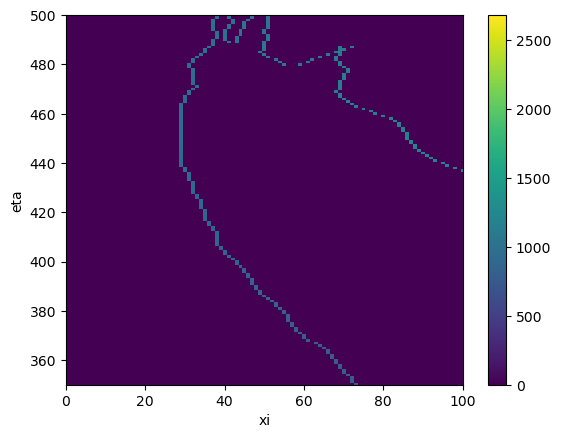

In [61]:
mask_x_transport_numbered.plot()
# mask_x_transport.plot()
plt.xlim(0,100)
plt.ylim(350,500)

(350.0, 500.0)

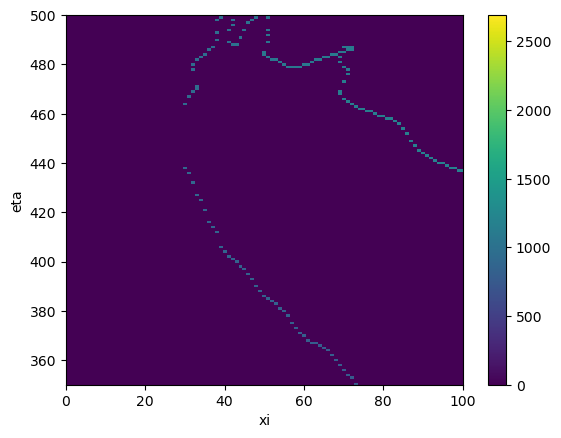

In [62]:
mask_y_transport_numbered.plot()
# mask_y_transport.plot()
plt.xlim(0,100)
plt.ylim(350,500)

In [80]:
### Code to extract distance in between contour coordinates, using length of diagonal if there is a bend.
#Loop through the contour, determining if diagonal is required or not, and save the distance along each segment. Then, cumulatively sum the distances along each segment to get the distance from the first point.
#If there is a bend in the contour, then half the diagonal distance is added to each side to avoid artifically inflating the along-contour distance metric, according to this diagram:

num_points = len(lat_along_contour)

# if there is a bend in the contour, add the distance using the half-length of the diagonal
# instead of the sum of 2 edges, to be more representative.
distance_along_contour = np.zeros((num_points))

x_indices = np.sort(mask_x_transport_numbered.values[mask_x_transport_numbered.values>0])
y_indices = np.sort(mask_y_transport_numbered.values[mask_y_transport_numbered.values>0])

skip = False
# note dxu and dyt do not vary in x, so we can just take the first value (as long as there is no land there,
# which for this latitude range there is not. If using a different latitude range, choose an x value that is
# not a nan/land for the entire latitude range
dxu = np.divide(1,pm)
dyt = np.divide(1,pn)

for count in range(1, num_points):
    if skip == True:
        skip = False
        continue
    if count in y_indices:
        if count + 1 in y_indices:
            # note dxu and dyt do not vary in x:
            jj = np.where(mask_y_transport_numbered==count)#[0]
            # print(count, jj)
            distance_along_contour[count-1] = (dxu[jj])#[0]
        else:
            jj0 = np.where(mask_y_transport_numbered==count)#[0]
            jj1 = np.where(mask_x_transport_numbered==count+1)#[0]
            half_diagonal_distance = 0.5 * np.sqrt((dxu[jj0])**2 + (dyt[jj1])**2)
            distance_along_contour[count-1] = half_diagonal_distance
            distance_along_contour[count] = half_diagonal_distance
            # skip to next count:
            skip = True

    # count in x_indices:
    else:
        if count + 1 in x_indices:
            jj = np.where(mask_x_transport_numbered==count)#[0]
            distance_along_contour[count-1] = (dyt[jj])#[0]
        else:
            jj0 = np.where(mask_x_transport_numbered==count)#[0]
            jj1 = np.where(mask_y_transport_numbered==count+1)#[0]
            half_diagonal_distance = 0.5 * np.sqrt((dyt[jj0])**2 + (dxu[jj1])**2)
            distance_along_contour[count-1] = half_diagonal_distance
            distance_along_contour[count] = half_diagonal_distance
            # skip to next count:
            skip = True

# fix last value:
if distance_along_contour[-1] == 0:
    count = count + 1
    if count in y_indices:
        jj = np.where(mask_y_transport_numbered==count)#[0]
        distance_along_contour[-1] = (dxu[jj])#[0]
    else:
        jj = np.where(mask_x_transport_numbered==count)#[0]
        distance_along_contour[-1] = (dyt[jj])#[0]

# units are 10^3 km:
distance_along_contour = np.cumsum(distance_along_contour) / 1e3 / 1e3


# --- Select the indices for axis labels of specific longitudes,
# so we can plot transport vs distance but have longitude labels instead of length

distance_indices = np.zeros(9)

for i in np.arange(100, len(lon_along_contour.one)):
    # print(i)
    if (distance_indices[1]==0):
        if (lon_along_contour.one[i]>-160 and lon_along_contour.one[i]<-159):
            distance_indices[1] = lon_along_contour.contour_index.values[i]
    if (distance_indices[2]==0):
        if (lon_along_contour.one[i]>-120 and lon_along_contour.one[i]<-119):
            distance_indices[2] = lon_along_contour.contour_index.values[i]
    if (distance_indices[3]==0):
        if (lon_along_contour.one[i]>-80  and lon_along_contour.one[i]<-79):
             distance_indices[3] = lon_along_contour.contour_index.values[i]
    if (distance_indices[4]==0):
        if (lon_along_contour.one[i]>-40 and lon_along_contour.one[i]<-39):
            distance_indices[4] = lon_along_contour.contour_index.values[i]
    if (distance_indices[5]==0):
        if (lon_along_contour.one[i]>0 and lon_along_contour.one[i]<1):
            distance_indices[5] = lon_along_contour.contour_index.values[i]
    if (distance_indices[6]==0):
        if (lon_along_contour.one[i]>40 and lon_along_contour.one[i]<41):
            distance_indices[6] = lon_along_contour.contour_index.values[i]
    if (distance_indices[7]==0):
        if (lon_along_contour.one[i]>80 and lon_along_contour.one[i]<81):
            distance_indices[7] = lon_along_contour.contour_index.values[i]
    if (distance_indices[8]==0):
        if (lon_along_contour.one[i]>120 and lon_along_contour.one[i]<121):
            distance_indices[8] = lon_along_contour.contour_index.values[i]

#distance_indices[13] = len(lon_along_contour.contour_index.values)-1

print('Debugging lenght error in the to_netcdf function:')
print('contour_index_array len, lon_along_contour/lat_along_contour/distance_along_contour shapes:')
print(len(contour_index_array))
print(lon_along_contour.shape)
print(lat_along_contour.shape)
print(distance_along_contour.shape)

Debugging lenght error in the to_netcdf function:
contour_index_array len, lon_along_contour/lat_along_contour/distance_along_contour shapes:
2690
(2690,)
(2690,)
(2690,)


In [78]:
lon_along_contour

array([156.09445372, 156.09445372, 156.29986293, ..., 155.6855897 ,
       155.88969527, 156.09445372])